<a href="https://www.kaggle.com/code/maheshshantaram/bengaluru-nammametro-ridership-analysis?scriptVersionId=232065816" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# Library installs and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import norm, linregress, t
from IPython.display import Markdown

filename = "/kaggle/input/bengaluru-nammametro-daily-ridership/NammaMetro_Ridership_Dataset.csv"
df = pd.read_csv(filename)

# **0. Table of Contents**

### 1. [One Day on NammaMetro](#1.-One-Day-on-NammaMetro)

> `Day of Week` and `Total Riders`
>
> Missing Days
>
> The Dataset at a Glance

### 2. ["The Metro is Getting Crowded!"](#2.-%E2%80%9CThe-Metro-is-Getting-Crowded!%E2%80%9D)

> Top 10 Busiest Days (Commuter Traffic)
>
> Top 10 Least Busy Days (Weekend Traffic)

### 3. [One Week on NammaMetro](#3.-One-Week-on-NammaMetro)

> Total Ridership over the Last 7 Days
>
> Total Ridership by Day of Week
>
> Average Ridership by Day of Week
>
> Ridership Patterns by Payment Method

### 4. [Three Traffic Bands, Two Kinds of Patrons, One Metro](#4.-Three-Traffic-Bands,-Two-Kinds-of-Patrons,-One-Metro)

> Ridership Patterns: `Commute` vs `Casual` rides by `Traffic Band`

### 5. [One Month on NammaMetro](#5.-One-Month-on-NammaMetro)

> The Spread of Data
>
> Ebb and Flow of Daily Passenger Traffic
>
> A Wave Rides NammaMetro

### 6. [The Long Weekend and Other Phenomena](#6.-The-Long-Weekend-and-Other-Phenomena)

> Sankranti and Something Else
>
> Ridership Towers – Users and Payments

### 7. [Metro Enables the Visitor Economy](#7.-Metro-Enables-the-Visitor-Economy)

> Come for the sporting and entertainment, stay for the vibes

### 8. [Fare Hike of February 2025 – Impact Analysis](8.-Fare-Hike-of-February-2025-%E2%80%93-Impact-Analysis)

> Did users abandon NammaMetro in the days following the fare hike?
> 
> The Bigger Picture: Migration vs. Abandonment  

### 9. [The Conspiracy Theory 😈](#9.-The-Conspiracy-Theory-%F0%9F%98%88)
> Did BMRCL Stage a Payments Disruption to Nudge Users Toward Smart Cards?

_____
# **1. One Day on NammaMetro**

Let's take a look at source of data that informs the analysis to follow.

<div style="text-align: center; margin: 20px;"><img src="https://github.com/thecont1/namma-metro-ridership-tracker/blob/main/images/nammametro_datapage.png?raw=true" style="border: 0.5px solid black; max-width: 75%; height: auto; box-shadow: 2px 2px 5px #8b2183;" alt="BMRCL Ridership Data Page" /></div>

*Namma Metro publishes a breakdown of ridership by payment methods used daily by passengers entering the system.*

Source: [https://english.bmrc.co.in/ridership/](https://english.bmrc.co.in/ridership/)

In [76]:
# Earliest Record
df.head(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Total Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
0,26-10-2024,353460,352496,853,43,68,241883,7444,512,177279,49351,95571,32357


In [77]:
# Latest Record
df.tail(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Total Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
149,05-05-2025,416198,415630,88,32,448,217786,11352,138,175376,50424,94205,30747


### Let's create two additional useful features: `Day of Week` and `Total Riders`

In [78]:
df['Total Riders'] = df.loc[:, ['Total Smart Cards', 
                                'Total Tokens', 
                                'Total NCMC', 
                                'Group Ticket', 
                                'Total QR']].sum(axis=1).astype('Int64')
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%d-%m-%Y')
df['Day of Week'] = df['Record Date'].dt.day_name()

display(df.tail())

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Total Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm,Total Riders,Day of Week
145,2025-04-29,440446,439922,276,55,193,212405,11539,145,177165,51117,94671,31377,841700,Tuesday
146,2025-04-30,343578,343235,98,53,192,222973,9302,100,181382,51720,97821,31841,757335,Wednesday
147,2025-05-02,349778,349361,224,36,157,217440,9009,179,163742,45604,88895,29243,740148,Friday
148,2025-05-04,135141,134519,525,73,24,249681,4138,99,178146,48069,99341,30736,567205,Sunday
149,2025-05-05,416198,415630,88,32,448,217786,11352,138,175376,50424,94205,30747,820850,Monday


In [79]:
number_of_days = 180

date_range = pd.date_range(start=df['Record Date'].min(), 
                          end=df['Record Date'].max(), 
                          freq='D')
complete_df = pd.DataFrame({'Record Date': date_range})
complete_df = complete_df.merge(df, on='Record Date', how='left')
complete_df['Formatted_Date'] = complete_df['Record Date'].dt.strftime('%b %d')

print("="*40)
print(f"Missing Data – Last 10 Dates")
print("="*40)
missing_data = complete_df.tail(number_of_days).copy()
missing_data['Day of Week'] = missing_data['Record Date'].dt.day_name()
missing_data = missing_data[missing_data['Total Riders'].isna()][['Record Date', 'Day of Week', 'Total Riders']]
display(missing_data.tail(10))

# For use later when creating the stacked area chart
imputed_days = missing_data['Record Date'].dt.strftime('%Y-%m-%d').tolist()

Missing Data – Last 10 Dates


,Record Date,Day of Week,Total Riders
168,2025-04-12,Saturday,<NA>
169,2025-04-13,Sunday,<NA>
171,2025-04-15,Tuesday,<NA>
173,2025-04-17,Thursday,<NA>
174,2025-04-18,Friday,<NA>
176,2025-04-20,Sunday,<NA>
177,2025-04-21,Monday,<NA>
180,2025-04-24,Thursday,<NA>
187,2025-05-01,Thursday,<NA>
189,2025-05-03,Saturday,<NA>


## **The Dataset at a Glance** 

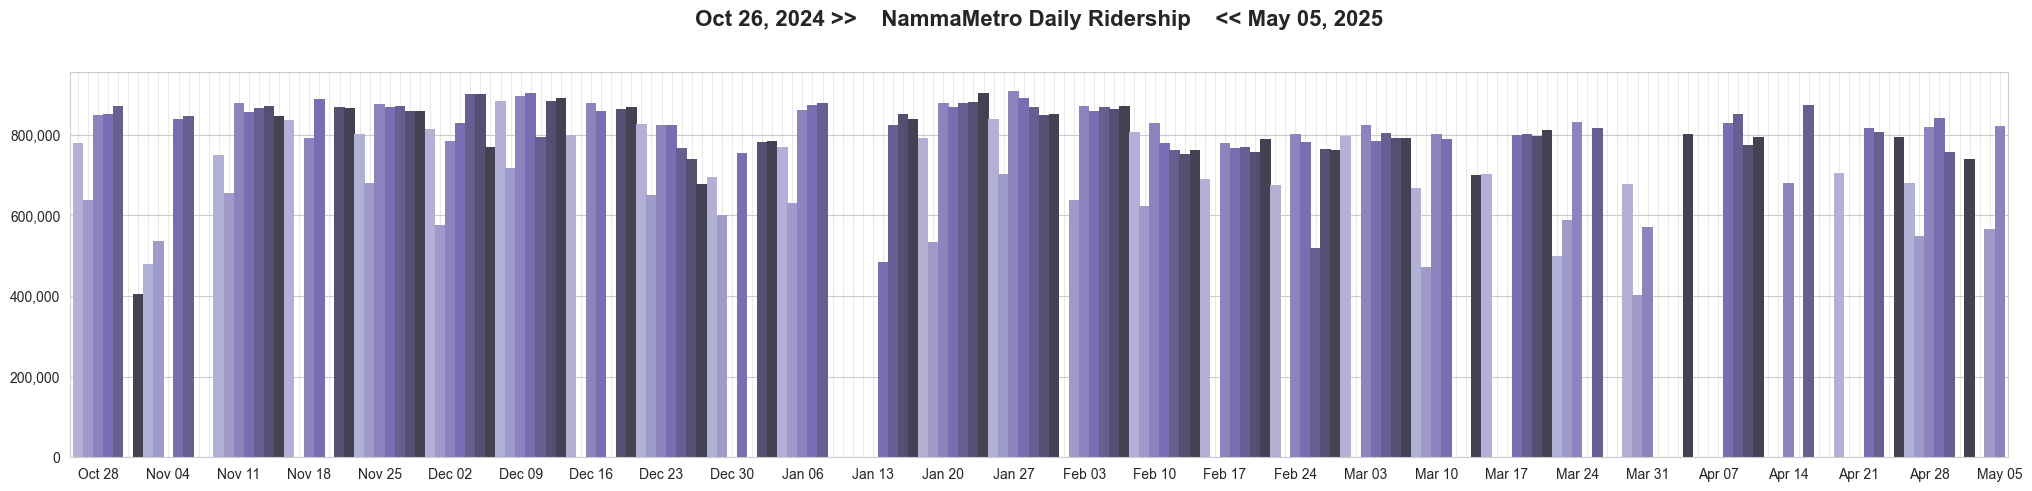

In [80]:

ax = complete_df\
    .plot(x='Formatted_Date',
          y='Total Riders',
          kind='bar',
          xlabel='',
          ylabel='',
          figsize=(25,5),
          width=1.05,
          color=sns.color_palette('Purples_d', 7),
          legend=False,
          alpha=1.0,
          rot=0)
for patch in ax.patches:
    patch.set_linewidth(0)

earliest_date = df['Record Date'].min().strftime('%b %d, %Y')
latest_date = df['Record Date'].max().strftime('%b %d, %Y')
plt.title(f"{earliest_date} >>    NammaMetro Daily Ridership    << {latest_date}", 
          fontsize=16, y=1.1, fontweight='bold')

xticks = plt.gca().get_xticklabels()
for i, (date, riders) in enumerate(zip(complete_df['Record Date'], complete_df['Total Riders'])):
    if date.weekday() == 0:
        xticks[i].set_visible(True)
        xticks[i].set_fontsize(10)
    else:
        xticks[i].set_visible(False)

plt.ylim(bottom=0)
plt.yticks(fontsize=10)
plt.grid(True, axis='x', alpha=0.4)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.show()

<div style="text-align: center;"><img src="https://github.com/thecont1/namma-metro-ridership-tracker/blob/main/images/photo_DSF1740.jpg?raw=true" style="border: 0.5px solid black; max-width: 75%; height: auto; box-shadow: 5px 5px 0px #ff6600" alt="View from Sri Balagangadharanatha Swamiji Station, Hosahalli (Purple Line)" /></div>

<center>
<br>View from <code>Ⓜ️ Sri Balagangadharanatha Swamiji Station, Hosahalli</code>  🟣 Purple Line
<br><br><small><i>&copy; 2023 Mahesh Shantaram. All Rights Reserved.<i></small>
</center>

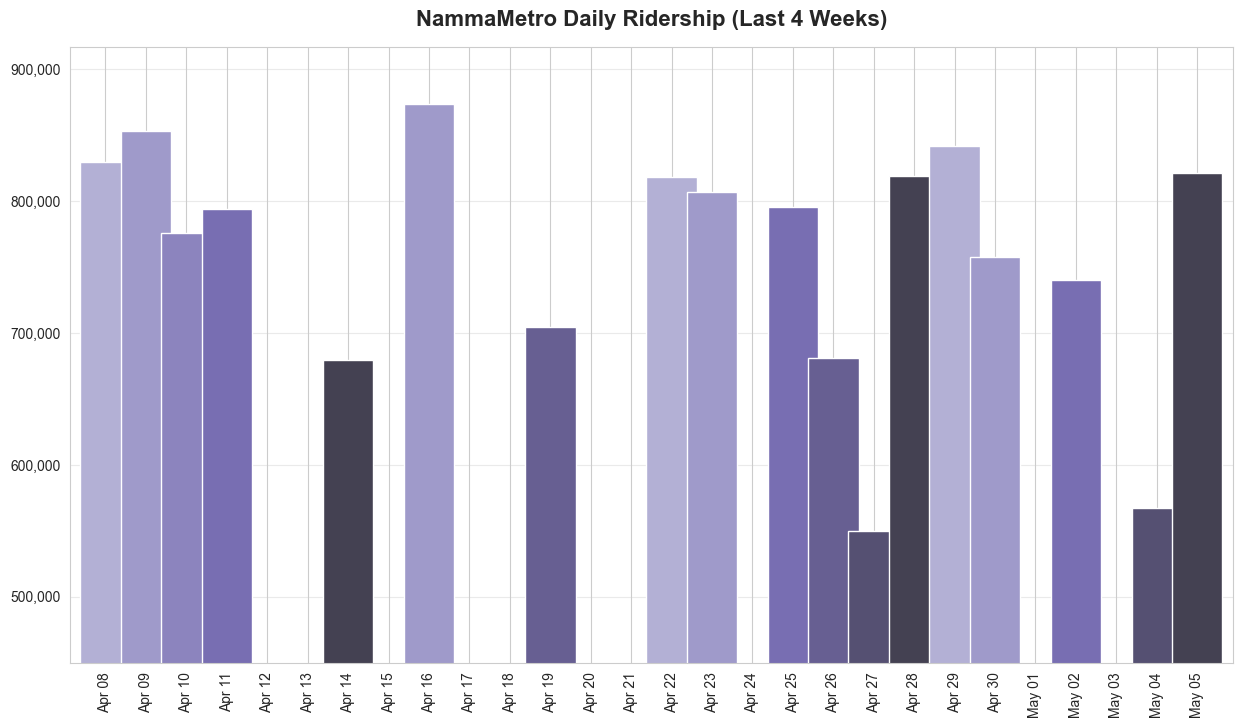

In [81]:
number_of_days = 28; base_value = 450000

truncated_df = complete_df.tail(number_of_days)
ax = truncated_df\
    .plot(x='Formatted_Date',
          y='Total Riders',
          kind='bar',
          xlabel='',
          ylabel='',
          figsize=(15,8),
          width=1.25,
          color=sns.color_palette('Purples_d', 7),
          legend=False,
          rot=90)

plt.title(f"NammaMetro Daily Ridership (Last {number_of_days//7} Weeks)",
          fontsize=16, y=1.02, fontweight='bold')

xticks = plt.gca().get_xticklabels()
plt.ylim(bottom=base_value)
plt.yticks(fontsize=10)
plt.grid(True, axis='y', alpha=0.4)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.show()

### Looks like a mouth with a few broken teeth!

What sort of data imputation makes sense here? 

When the dataset grows large enough over several months, it makes sense to fill unreported dates with an average of similar days, e.g. If a weekday Tuesday was missing, take the average of the last 4 available weekday Tuesdays.

_____
# **2. “The Metro is Getting Crowded!”**

<div style="text-align: center; margin: 20px;"><img src="https://github.com/thecont1/namma-metro-ridership-tracker/blob/main/images/nammametro_record1.png?raw=true" style="border: 0.5px solid #000000; max-width: 75%; height: auto; box-shadow: 2px 2px 5px #ffcb1c;" alt="NammaMetro crossed a daily ridership of 700,000 in October 2023" /></div>

*NammaMetro crossed a daily ridership of 700,000 in October 2023*


In [82]:
# Top 10 Busiest Days - The Commuters
busiest_days = df[['Record Date', 'Day of Week', 'Total Riders']].sort_values('Total Riders', ascending=False)
busiest_days.reset_index(drop=True, inplace=True)
busiest_days.index = range(1, len(busiest_days) + 1)
busiest_days.head(10)

,Record Date,Day of Week,Total Riders
1,2025-01-27,Monday,909522
2,2024-12-10,Tuesday,903928
3,2025-01-24,Friday,902476
4,2024-12-04,Wednesday,901475
5,2024-12-05,Thursday,901230
6,2024-12-09,Monday,895461
7,2025-01-28,Tuesday,891111
8,2024-12-13,Friday,890143
9,2024-11-19,Tuesday,889113
10,2024-12-07,Saturday,883300


👆🏼 In December 2024, NammaMetro's single-day ridership crossed 900,000 for the first time!

The ridership hit a record of 700,000 passengers in October 2023. It took just a little over a year to add 200,000 riders/day to the system.

In [83]:
# Least Busy Days so far - The Weekenders
busiest_days.tail(10)

,Record Date,Day of Week,Total Riders
141,2025-04-27,Sunday,549663
142,2024-11-03,Sunday,536524
143,2025-01-19,Sunday,534139
144,2025-02-26,Wednesday,520284
145,2025-03-22,Saturday,498494
146,2025-01-14,Tuesday,484293
147,2024-11-02,Saturday,480284
148,2025-03-09,Sunday,473005
149,2024-11-01,Friday,404342
150,2025-03-30,Sunday,402795


👆🏼 Sundays, holidays (state and national) and major festivals are when people take a break from the metro.

<div style="text-align: center; margin: 20px"><img src="https://github.com/thecont1/namma-metro-ridership-tracker/blob/main/images/photo_MS202303-DerSpiegel1021.jpg?raw=true" style="border: 0.5px solid black; max-width: 75%; height: auto; box-shadow: 5px 5px 0px #ff66dd" alt="Sunday Shoppers on Avenue Road, Chickpete Metro Station (Green Line)" /></div>

<center>
Sunday Shoppers on Avenue Road <code>Ⓜ️ Chickpete Metro Station</code> 🟢 Green Line<br><br>
<small><i>&copy; 2023 Mahesh Shantaram. All Rights Reserved.<i></small>
</center>

_____
# **3. One Week on NammaMetro**

### Total Daily Ridership over the Last 7 days

In [84]:
df[['Record Date', 'Day of Week', 'Total Riders']].tail(7)

,Record Date,Day of Week,Total Riders
143,2025-04-27,Sunday,549663
144,2025-04-28,Monday,818938
145,2025-04-29,Tuesday,841700
146,2025-04-30,Wednesday,757335
147,2025-05-02,Friday,740148
148,2025-05-04,Sunday,567205
149,2025-05-05,Monday,820850


### Total Daily Ridership by Day of Week

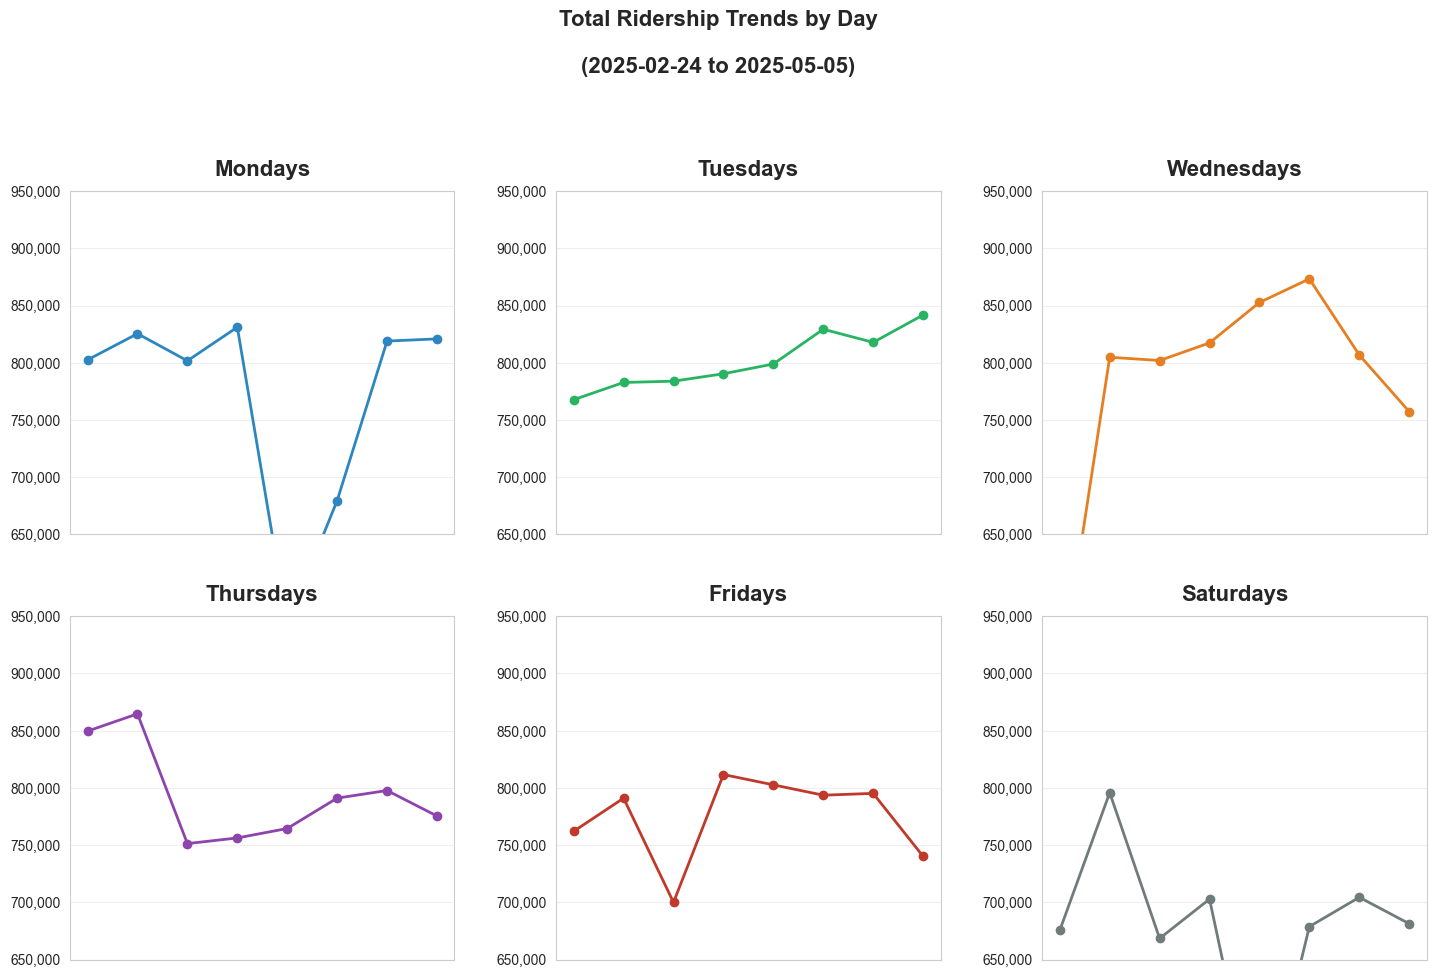

In [85]:
number_of_days = 7 * 8
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
colors = {
    'Monday':    '#2E86C1', # Blue
    'Tuesday':   '#28B463', # Green
    'Wednesday': '#E67E22', # Orange
    'Thursday':  '#8E44AD', # Purple
    'Friday':    '#C0392B', # Red
    'Saturday':  '#707B7C', # Gray
    'Sunday':    '#F1C40F'  # Yellow
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.set_style("whitegrid")
axes = axes.flatten()

def plot_day_data(ax, day, idx):
    day_data = df[df['Day of Week']==day][['Record Date', 'Total Riders']].tail(int(number_of_days/7))
    
    ax.plot(range(len(day_data)), day_data['Total Riders'], 
            marker='o', markersize=6, linewidth=2, 
            color=colors[day], label=day)
    
    ax.set_title(f'{day}s', fontsize=16, y=1.02, fontweight='bold')
    ax.set_ylabel('', fontsize=11)
    ax.grid(True, axis='both', alpha=0.3)
    ax.set_xticks([])
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    ax.set_ylim(650000, 950000)

for idx, day in enumerate(days):
    plot_day_data(axes[idx], day, idx)

start_date = df[df['Day of Week']=='Monday'].tail(int(number_of_days/7)).reset_index().iloc[0, 1].strftime('%Y-%m-%d')
end_date = df['Record Date'].max().strftime('%Y-%m-%d')
fig.suptitle(f"Total Ridership Trends by Day\n\n({start_date} to {end_date})", 
             fontsize=16, y=1, fontweight='bold')
plt.tight_layout(pad=3.0)
plt.show()

This is a series of line plots showing the trend in total ridership for each day of the week over the past several weeks. This makes it easy to spot patterns for specific days and answer several key questions concerning: 

- consistency (*"Are there regular patterns in how ridership fluctuates?"*)

- trends (*"Are there seasonal or cyclical patterns in day-specific ridership?"*)

- anomalies (*"Which days experienced unusual spikes or dips?"*)

- operational planning (*"Are there systematic differences between different days of the week?"*)

- recovery patterns (*"Are there lasting impacts from major events?"*)

### Average Daily Ridership by Day of Week

In [86]:
print("Number of data points available for each day of the week:")
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%Y-%m-%d')
df['Day of Week'] = df['Record Date'].dt.day_name()
df['Day of Week'].value_counts()[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

Number of data points available for each day of the week:


Day of Week
Monday       22
Tuesday      24
Wednesday    22
Thursday     18
Friday       23
Saturday     23
Sunday       18
Name: count, dtype: int64

In [87]:
# Configure parameters to calculate day of week averages
number_of_days = 7*13
end_date = pd.to_datetime('2025-02-08')
start_date = max(end_date - pd.Timedelta(days=number_of_days-1), df['Record Date'].min())
exclude_dates = ['2025-01-14', '2025-01-15', '2025-01-16', '2025-01-25']

In [88]:
# Average Daily Ridership by Day of Week: the weekly_average data
rename_map = {
    'Total Smart Cards': 'Smart Cards',
    'Total Tokens': 'Tokens',
    'Total NCMC': 'NCMC',
    'Total QR': 'QR',
    'Day of Week_x': 'Day of Week'
}
payment_columns = ['Smart Cards', 'NCMC', 'Tokens', 'QR', 'Group Ticket']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

mask = (df['Record Date'] >= start_date) & (df['Record Date'] <= end_date)
if exclude_dates:
    exclude_dates = pd.to_datetime(exclude_dates)
    mask &= ~df['Record Date'].isin(exclude_dates)

weekly_average = (df[mask]
                 .rename(columns=rename_map)
                 .groupby('Day of Week')[payment_columns]
                 .mean()
                 .reindex(day_order))
weekly_average = weekly_average.apply(
    lambda x: pd.to_numeric(x.fillna(0), errors='coerce')
    .round()
    .astype('Int64'))
weekly_average['Total Riders'] = weekly_average.sum(axis=1)

print("=" * 45)
print("Average Daily Ridership by Day of Week")
print("=" * 45)
display(weekly_average)

Average Daily Ridership by Day of Week


,Smart Cards,NCMC,Tokens,QR,Group Ticket,Total Riders
Day of Week,,,,,,
Monday,441535,12783,212330,192376,522,859546
Tuesday,452002,13529,211532,178955,526,856544
Wednesday,438248,12995,208250,194964,629,855086
Thursday,451271,13299,201128,185002,543,851243
Friday,427227,12636,208870,186383,649,835765
Saturday,333868,8792,236786,222606,810,802862
Sunday,177230,4969,250348,205058,655,638260


`weekly_average` summarizes three months of metro ridership data showing the **typical number of passengers using each payment method on different days of the week**. It eliminates dates that display anomalous behaviour so that the result is more representative of an average week. **This table forms the foundation for our analysis of commuter patterns and weekend behavior ahead in the analysis.**

### Average Daily Ridership by Payment Method

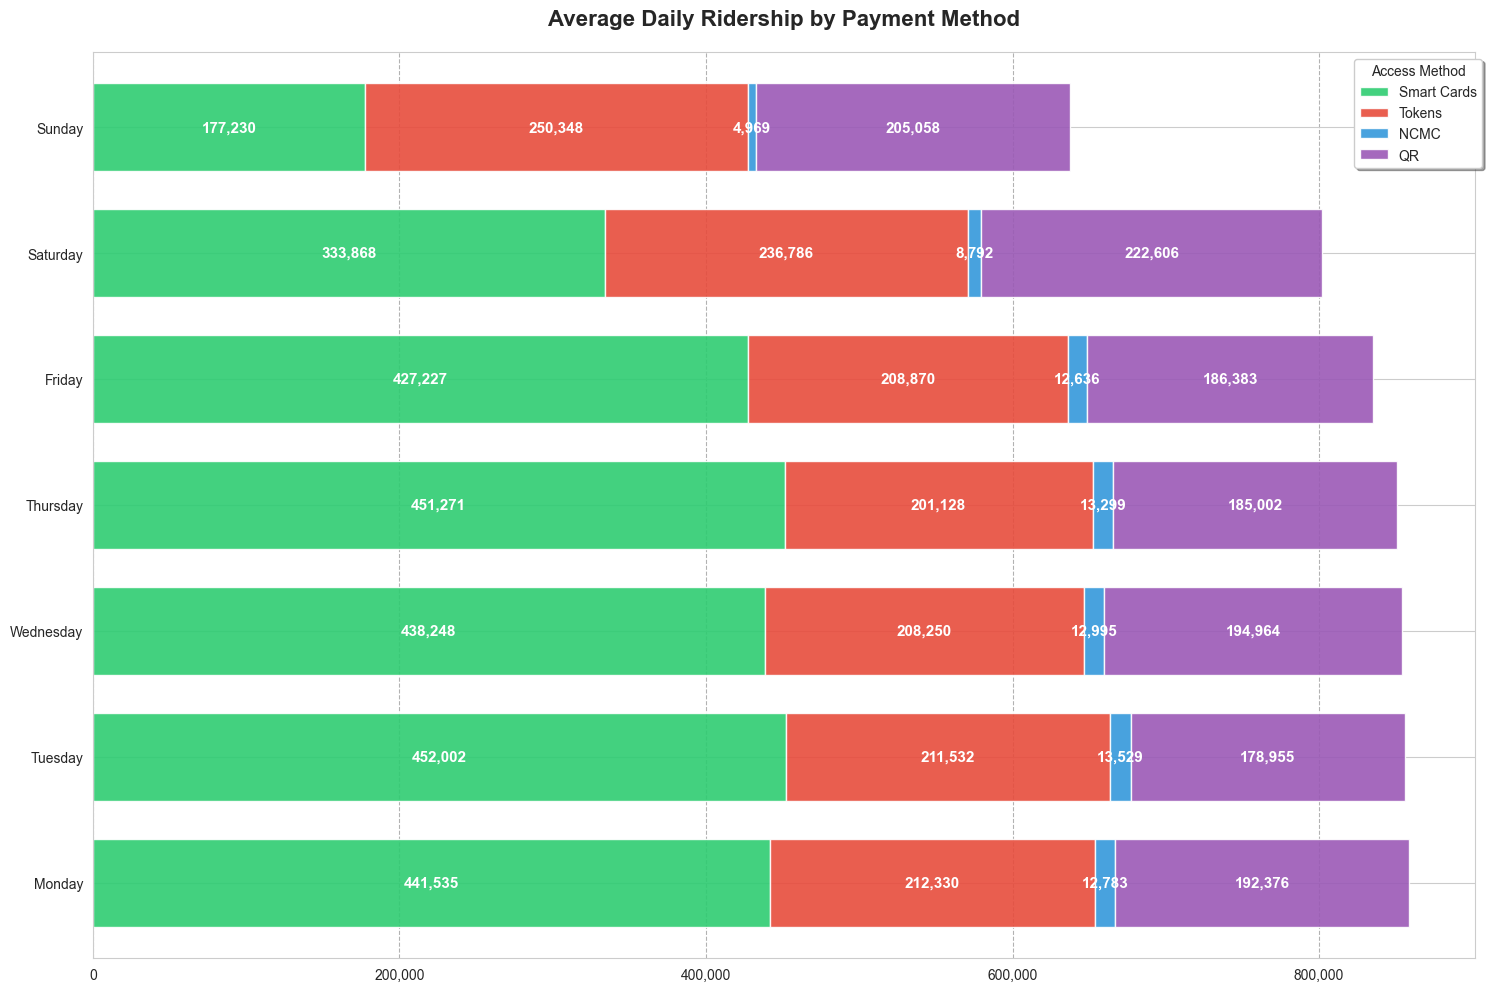

In [89]:

colors = {
    'Smart Cards': '#2ecc71',   # green
    'NCMC': '#3498db',         # blue
    'Tokens': '#e74c3c',      # red
    'QR': '#9b59b6'          # purple
}

ax = weekly_average.loc[:, ['Smart Cards', 'Tokens', 'NCMC', 'QR']].plot(
                             kind='barh', stacked=True, ylabel='',
                             color=[colors[col] for col in ['Smart Cards', 'Tokens', 'NCMC', 'QR']],
                             figsize=(15, 10), width=0.7, rot=0, alpha=0.9)

for c in ax.containers:
    labels = labels = [f'{int(v):,}' if v >= 4000 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=11, color='white', fontweight='bold')

plt.title('Average Daily Ridership by Payment Method', 
          fontsize=16, 
          y=1.02, 
          fontweight='bold')
plt.legend(title='Access Method', 
          bbox_to_anchor=(1.01, 1), 
          loc='best',
          frameon=True,
          fancybox=True,
          shadow=True)
plt.grid(axis='x', 
         linestyle='--', 
         alpha=0.6,
         color='gray')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.tight_layout()
plt.show()

#### 👆🏼 Surprising find: Smart Card and NCMC usage peaks during the week; Tokens and QR peaks on weekends.
> 
> - From Monday to Thursday, Smart Card and NCMC usage – typically used by regular metro riders commuting to work – averages 450,000 and 12,000 respectively.
> 
> - Tokens and QR payments, typically used by non-regular metro riders, reach peak usage on Sundays. This suggests weekend and holiday demand is driven by casual users, e.g. road users who switch to public transport on the weekends.
> 
>   - **Commuters:** Officegoers who are committed to using public transport. We assume they use stored deposit value digital payment methods like Smart Cards and NCMC for efficiency. 
> 
>   - **Casual Users:** People who use public transport to run errands, get around on the weekends, etc. Typically, they use Tokens, QR, and Group Tickets to access the system.
> 
> - Looking at usage patterns by days of the week, there appears to be _three distinct traffic bands_ in Bangalore City:
> 
>   - **Weekdays:** Without doubt, Mondays through Thursdays see heavy ridership as the metro ferries people to work and back
> 
>   - **Weekend:** Total ridership on Sundays dips to 50% of the average Weekday. 
>
>   - **Weekend Lite:** Friday begins to exhibit weekend-like behaviour. But then, _Saturday is a full working day for many in this city._

_____
# **4. Three Traffic Bands, Two Kinds of Patrons, One Metro**

<br>
**Ridership Patterns: `Commute` vs `Casual` rides by `Traffic Band`**

Given what we have learned so far, let us introduce new data features into our dataframe:

- `Commute`: Sum of Smart Cards and NCMC users, representing regular travelers who prefer reusable payment methods

- `Casual`: Sum of Tokens, QR tickets, and Group tickets, representing occasional travelers who opt for single-journey payment methods

- `Traffic Band`: Weekday (Mon-Thu), Weekend Lite (Fri-Sat) or Weekend (Sun)

In [90]:
# Create df2 with new features for further analysis
df2 = df.copy()

# Create additional features: Day of Week, Traffic Band
df2['Day of Week'] = df2['Record Date'].dt.strftime('%A')
df2['Traffic Band'] = 'Weekday'
df2.loc[(df2['Record Date'].dt.dayofweek >= 4), 'Traffic Band'] = 'Weekend Lite'
df2.loc[(df2['Record Date'].dt.dayofweek == 6), 'Traffic Band'] = 'Weekend'

# Create additional features Commute, Casual and Total
df2['Commute'] = df2['Total Smart Cards'] + df2['Total NCMC']
df2['Casual'] = df2['Total Tokens'] + df2['Total QR'] + df2['Group Ticket']
df2['Total'] = df2['Commute'] + df2['Casual']

# Select features for new dataframe
df2.rename(columns={
    # 'Record Date': 'Date',
    # 'Day of Week':,
    'Total Smart Cards': 'Smart Cards',
    'Total NCMC': 'NCMC',
    # 'Commute':,
    'Total Tokens': 'Tokens',
    'Total QR': 'QR',
    # 'Group Ticket':,
    # 'Casual':,
    # 'Total':,
}, inplace=True)

df2 = df2.assign(**{col: df2[col].astype(int) for col in df2.select_dtypes(include=['float64']).columns})
df2 = df2[['Record Date', 'Day of Week', 'Traffic Band', 
           'Smart Cards', 'NCMC', 'Commute', 
           'Tokens', 'QR', 'Group Ticket', 'Casual', 
           'Total']]
display(df2)

,Record Date,Day of Week,Traffic Band,Smart Cards,NCMC,Commute,Tokens,QR,Group Ticket,Casual,Total
0,2024-10-26,Saturday,Weekend Lite,353460,7444,360904,241883,177279,512,419674,780578
1,2024-10-27,Sunday,Weekend,176278,4278,180556,250124,205910,458,456492,637048
2,2024-10-28,Monday,Weekday,452257,11076,463333,208014,177629,160,385803,849136
3,2024-10-29,Tuesday,Weekday,452299,10948,463247,205421,182210,407,388038,851285
4,2024-10-30,Wednesday,Weekday,425759,9975,435734,233366,201583,198,435147,870881
...,...,...,...,...,...,...,...,...,...,...,...
145,2025-04-29,Tuesday,Weekday,440446,11539,451985,212405,177165,145,389715,841700
146,2025-04-30,Wednesday,Weekday,343578,9302,352880,222973,181382,100,404455,757335
147,2025-05-02,Friday,Weekend Lite,349778,9009,358787,217440,163742,179,381361,740148
148,2025-05-04,Sunday,Weekend,135141,4138,139279,249681,178146,99,427926,567205


## 💡 The Weekend Lite Crossover Phenomenon

In [91]:
# Weekly Ridership Pattern Table
traffic_bands = {
    'Monday': ('Weekday', '#e6f0ff'),      # Slightly deeper blue-white
    'Tuesday': ('Weekday', '#e6f0ff'),
    'Wednesday': ('Weekday', '#e6f0ff'),
    'Thursday': ('Weekday', '#e6f0ff'),
    'Friday': ('Weekend Lite', '#ffe6e6'),  # Slightly deeper pink-white
    'Saturday': ('Weekend Lite', '#ffe6e6'),
    'Sunday': ('Weekend', '#f0e6ff')        # Slightly deeper purple-white
}
table_lines = []
table_lines.append("<center><table style='color: black'>")
headers = ['Day of Week', 'Traffic Band', 'Commute', 'Casual', 'Total']
table_lines.append("<tr style='background-color: black; color: white'><th>" + "</th><th>".join(headers) + "</th></tr>")
weekly_average['Commute'] = weekly_average['Smart Cards'] + weekly_average['NCMC']
weekly_average['Casual'] = weekly_average['Tokens'] + weekly_average['QR'] + weekly_average['Group Ticket']
weekly_average['Total'] = weekly_average['Commute'] + weekly_average['Casual']

for day in list(traffic_bands):
    band, color = traffic_bands[day]
    table_lines.append(f'<tr style="background-color: {color}">')
    row_data = [
        day,
        band,
        f"{int(weekly_average.loc[day, 'Commute']):,}",
        f"{int(weekly_average.loc[day, 'Casual']):,}",
        f"{int(weekly_average.loc[day, 'Total']):,}"
    ]
    table_lines.append("    <td>" + "</td>    <td>".join(row_data) + "</td>")
    table_lines.append("</tr>")

table_lines.append("</table></center>")
display(Markdown(" ".join(table_lines)))

<center><table style='color: black'> <tr style='background-color: black; color: white'><th>Day of Week</th><th>Traffic Band</th><th>Commute</th><th>Casual</th><th>Total</th></tr> <tr style="background-color: #e6f0ff">     <td>Monday</td>    <td>Weekday</td>    <td>454,318</td>    <td>405,228</td>    <td>859,546</td> </tr> <tr style="background-color: #e6f0ff">     <td>Tuesday</td>    <td>Weekday</td>    <td>465,531</td>    <td>391,013</td>    <td>856,544</td> </tr> <tr style="background-color: #e6f0ff">     <td>Wednesday</td>    <td>Weekday</td>    <td>451,243</td>    <td>403,843</td>    <td>855,086</td> </tr> <tr style="background-color: #e6f0ff">     <td>Thursday</td>    <td>Weekday</td>    <td>464,570</td>    <td>386,673</td>    <td>851,243</td> </tr> <tr style="background-color: #ffe6e6">     <td>Friday</td>    <td>Weekend Lite</td>    <td>439,863</td>    <td>395,902</td>    <td>835,765</td> </tr> <tr style="background-color: #ffe6e6">     <td>Saturday</td>    <td>Weekend Lite</td>    <td>342,660</td>    <td>460,202</td>    <td>802,862</td> </tr> <tr style="background-color: #f0e6ff">     <td>Sunday</td>    <td>Weekend</td>    <td>182,199</td>    <td>456,061</td>    <td>638,260</td> </tr> </table></center>

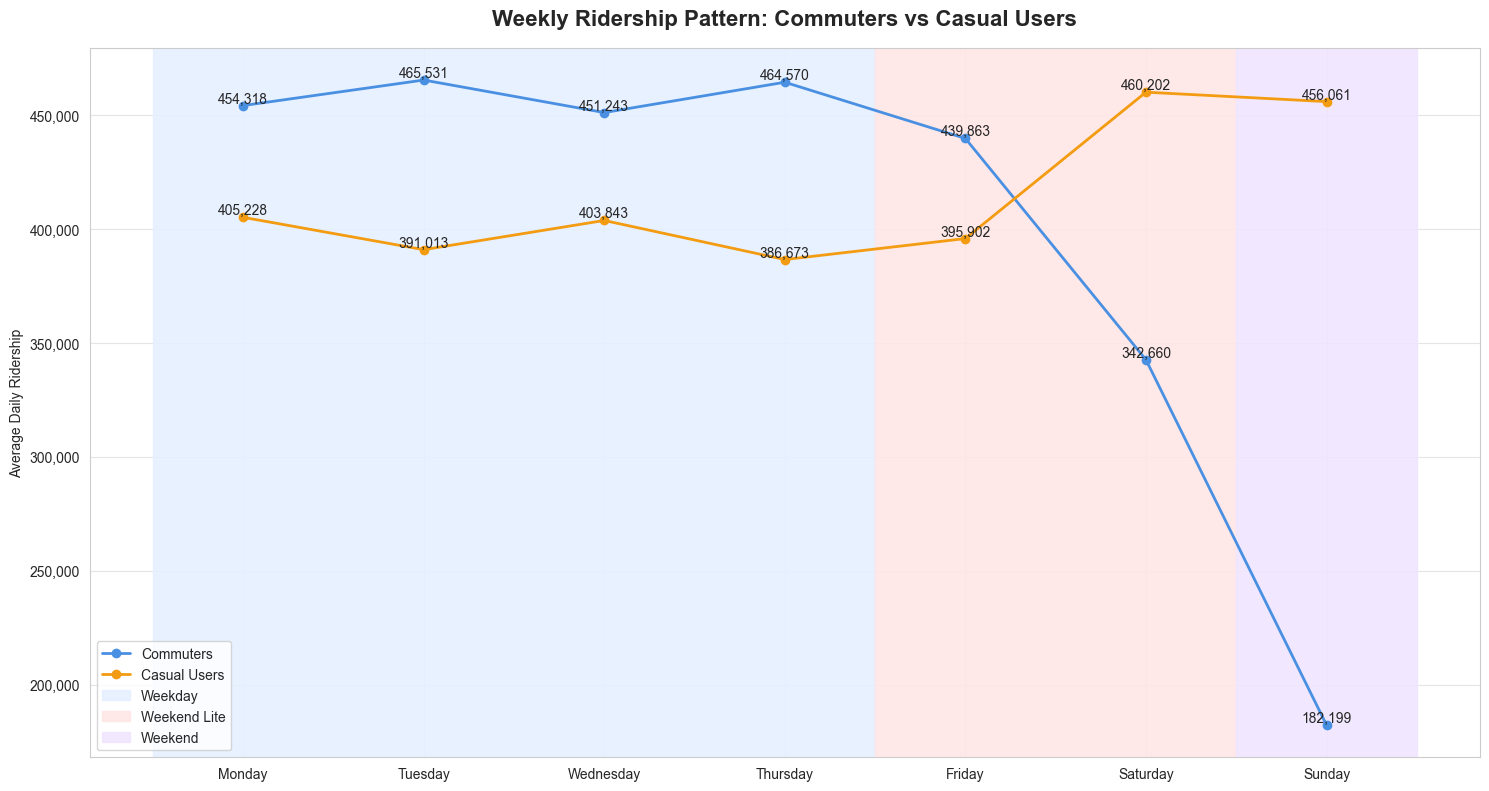

In [92]:
# Weekly Ridership Pattern Line Plot
plt.figure(figsize=(15, 8))
plt.plot(weekly_average.index, weekly_average['Commute'], 
         marker='o', linewidth=2, label='Commuters', 
         color='#4a90e2')
plt.plot(weekly_average.index, weekly_average['Casual'], 
         marker='o', linewidth=2, label='Casual Users', 
         color='#f39c12')

plt.axvspan(-0.5, 3.5, color='#e6f0ff', alpha=0.9, label='Weekday')
plt.axvspan(3.5, 5.5, color='#ffe6e6', alpha=0.9, label='Weekend Lite')
plt.axvspan(5.5, 6.5, color='#f0e6ff', alpha=0.9, label='Weekend')

plt.title('Weekly Ridership Pattern: Commuters vs Casual Users', 
         fontsize=16, y=1.02, fontweight='bold')
plt.xlabel('')
plt.ylabel('Average Daily Ridership')
plt.grid(True, alpha=0.5)
plt.legend(loc="lower left")

for category, col in [('Commuters', 'Commute'), ('Casual Users', 'Casual')]:
    for i, value in enumerate(weekly_average[col]):
        plt.text(i, value, f'{int(value):,}', 
                ha='center', va='bottom', fontsize=10)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.tight_layout()
plt.show()

### 💡 Two Kinds of Patrons
> 
> Ridership starts to dip on Fridays (perhaps due to liberal work-from-office policies in the IT industry or commuters preferring to use their personal vehicles.) For another segment of workers, Saturdays are as much a working day as the rest of the week.
>
> On Sundays, Smart Cards+NCMC usage sees a **~60% drop** from average Weekday levels. Tokens+QR **increases by ~15%**. 
> 
> #### This behaviour confirms the presence of two distinct types of users: **Commuters** and **Casual Users**. 
> 
> #### NammaMetro thus exhibits a dual role: *a commuter necessity on weekdays* and *a convenient transport option on weekends and holidays*

<br>

### 💡 Three Traffic Bands
>
> #### 💼 **Weekdays – _Just Another Manic Monday to Thursday_**
> 
> - This visualisation validates our hypothesis about Bangalore's distinct traffic bands and rider categories. During weekdays, defined as Monday to Thursday, commuter ridership dominates, showing a consistent pattern that reflects the city's work rhythm. These commuters rely on Smart Cards and NCMC to quickly move in and out of the NammaMetro system.
> 
> #### 🍻 **Weekend *Lite* – _Should I Stay or Should I Go?_**
> 
> - A remarkable crossover occurs in this band. Friday marks a clear shift where casual ridership begins to rise while commuter numbers decline. This pattern becomes even more pronounced on Saturday, where casual users nearly match commuter levels, suggesting a transformation in how the metro serves the city's needs – from a commuting utility to a general transportation option.
> 
> #### 🛌🏼 **Weekend – _A Day of Rest For Coders (But Not QR Coders)_**
> 
> - The starkest contrast appears on Sundays, where the two rider categories tell very different stories. Commuter numbers plummet to their lowest point while casual ridership reaches peak levels. This dramatic reversal reveals how the metro adapts to serve leisure travelers and weekend activities even as regular commuters largely stay home.
> 
> #### This pattern not only confirms our three-band traffic model but also reveals how different segments of Bangalore's population use the metro system throughout the week.

<div style="text-align: center; margin: 20px;"><img src="https://github.com/thecont1/namma-metro-ridership-tracker/blob/main/images/photo_MS202303-DerSpiegel0360.jpg?raw=true" style="border: 0.5px solid black; max-width: 75%; height: auto; box-shadow: 5px 5px 0px #00afff" alt="Benniganahalli Lake at Tin Factory Junction. Benniganahalli Metro (Purple Line)"></div>

<center>
Benniganahalli Lake at Tin Factory Junction <code>Ⓜ️ Benniganahalli </code> 🟣 Purple Line<br><br>
<small><i>&copy; 2023 Mahesh Shantaram. All Rights Reserved.<i></small>
</center>

______
# **5. One Month on NammaMetro**

Remember that NammaMetro fails to report ridership numbers on some days, so the monthly ridership totals calculated from the data is going to be only an approximate. However, we can still identify trends and patterns by analysing data movement on a granular level.

Here are the official monthly ridership stats as reported by BMRCL:

**Month**      | **Ridership**
---------------|---------------
2024 July      | 23,633,166
2024 August    | Unavailable
2024 September | 23,072,685
2024 October   | Unavailable
2024 November  | 23,613,895
2024 December  | 24,982,906
2025 January   | 24,914,736
2025 February  | 20,990,894

Let us try to construct the monthly ridership numbers from the available data. 

In [93]:
def trimmed_df(df, number_of_days=None, end_date=None, exclude_dates=None, weekly_average=None):
    """
    Return a trimmed DataFrame based on date parameters.
    If weekly_average is provided, uses it to impute missing values.
    Always includes is_imputed column (False for original data).
    """
    # Create working copy
    result = df.copy()
    
    # Handle date parameters
    end_date = pd.to_datetime(end_date) if end_date else result['Record Date'].max()
    if number_of_days:
        start_date = end_date - pd.Timedelta(days=number_of_days-1)
        result = result[result['Record Date'] >= start_date]
    result = result[result['Record Date'] <= end_date]
    
    # Handle exclusions
    if exclude_dates:
        exclude_dates = pd.to_datetime(exclude_dates)
        for date in exclude_dates:
            result = result[result['Record Date'] != date]    
    
    if weekly_average is not None:
        # Create complete date range
        date_range = pd.date_range(start=result['Record Date'].min(), 
                                 end=result['Record Date'].max(), 
                                 freq='D')
        date_range = date_range[~date_range.isin(exclude_dates)] if exclude_dates else date_range
        
        # Create base DataFrame with all dates
        complete = pd.DataFrame(index=date_range)
        complete.index.name = 'Record Date'
        complete = complete.reset_index()
        complete['Day of Week'] = complete['Record Date'].dt.strftime('%A')
        
        # Mark original dates before merge for accurate imputation flag
        result['_original'] = True
        
        # Merge with actual data
        result = complete.merge(result, how='left', on=['Record Date', 'Day of Week'])
        
        # Set imputation flag before filling values
        result['is_imputed'] = result['_original'].isna()
        result = result.drop('_original', axis=1)
        
        # Impute missing values
        numeric_cols = ['Smart Cards', 'NCMC', 'Tokens', 'QR', 'Group Ticket', 
                       'Commute', 'Casual', 'Total']
        for col in numeric_cols:
            if col in weekly_average.columns:
                mask = result[col].isna()
                result.loc[mask, col] = result.loc[mask, 'Day of Week'].map(weekly_average[col])
                result[col] = result[col].round().astype('Int64')
        
        # Ensure Traffic Band is set
        result['Traffic Band'] = 'Weekday'
        result.loc[result['Record Date'].dt.dayofweek >= 4, 'Traffic Band'] = 'Weekend Lite'
        result.loc[result['Record Date'].dt.dayofweek == 6, 'Traffic Band'] = 'Weekend'
    else:
        # If no imputation, all rows are original data
        result['is_imputed'] = False
    
    return result.sort_values('Record Date').reset_index(drop=True)

In [94]:

print("="*35)
print("Total Rides Served per Month ⁺")
print("="*35)

month_df = trimmed_df(df2[df2['Record Date'] >= '2024-11-01'], weekly_average=weekly_average)
month_df = pd.DataFrame({
    'Monthly Total (millions)': round(month_df.groupby(
     month_df['Record Date'].dt.to_period('M')
)['Total'].sum() / 1_000_000, 3),
    'Daily Average (thousands)': round(month_df.groupby(
     month_df['Record Date'].dt.to_period('M')
)['Total'].mean() / 1_000, 3)})

month_df.reset_index(inplace=True)
month_df.rename(columns={'Record Date': 'Year-Month'}, inplace=True)

display(month_df.loc[:len(month_df)-2, :])
print(f"⁺ Estimate based on available data as on {df2['Record Date'].max().strftime('%Y-%m-%d')}\n  plus extrapolation based on day averages.")

Total Rides Served per Month ⁺


,Year-Month,Monthly Total (millions),Daily Average (thousands)
0,2024-11,23.757,791.911
1,2024-12,24.716,797.302
2,2025-01,25.073,808.822
3,2025-02,21.225,758.041
4,2025-03,22.912,739.083
5,2025-04,23.577,785.884


⁺ Estimate based on available data as on 2025-05-05
  plus extrapolation based on day averages.


✨ The reported vs. estimated ridership numbers align closely, validating the accuracy of our extrapolations.

## The Spread of Data

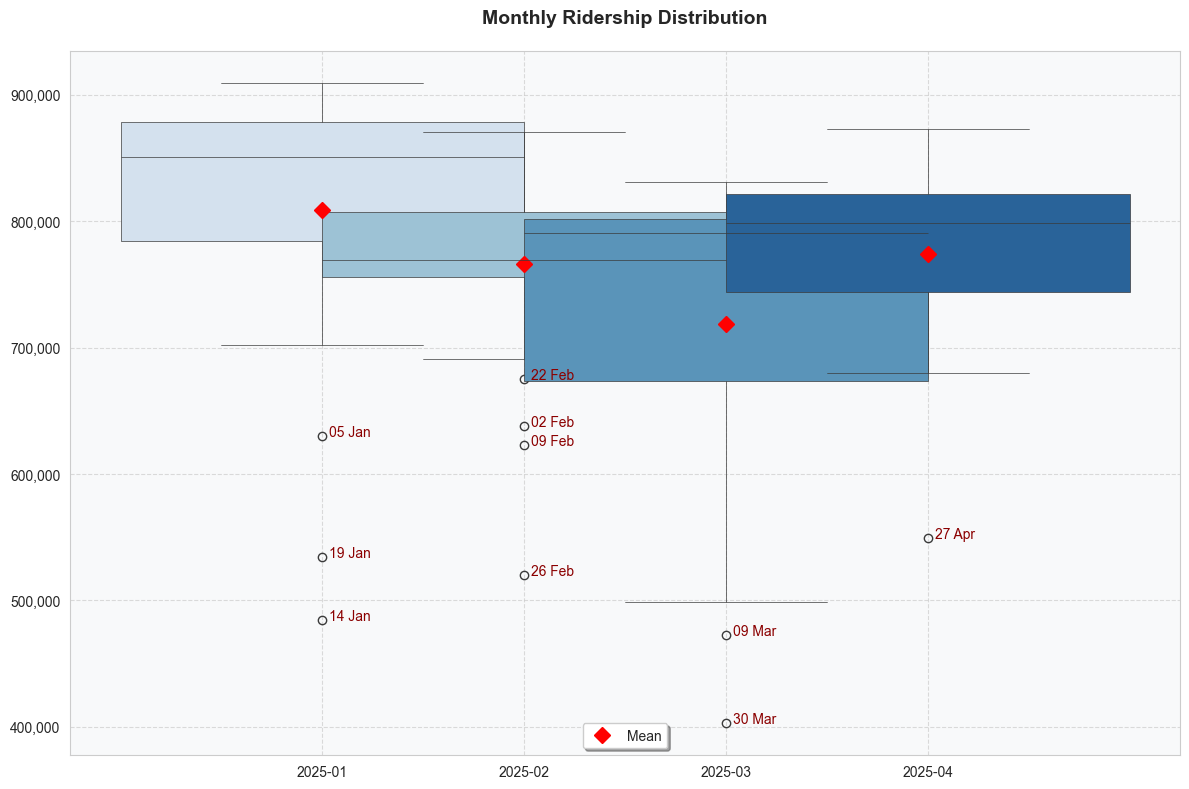

In [95]:
months_df = df2[df2['Record Date'] >= '2024-11-01']
latest_complete_month = months_df['Record Date'].max().to_period('M') - 1
months = pd.period_range(start=latest_complete_month-3, end=latest_complete_month, freq='M')
months_df = months_df[months_df['Record Date'].dt.to_period('M').isin(months)]

# Create the boxplot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=months_df,
            x=months_df['Record Date'].dt.to_period('M'),
            y='Total',
            hue=months_df['Record Date'].dt.to_period('M'),
            palette='Blues',
            width=2, 
            linewidth=0.5)
plt.title('Monthly Ridership Distribution', 
            pad=20, 
            fontsize=14,
            fontweight='bold')    
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
means = months_df.groupby(
    months_df['Record Date'].dt.to_period('M'))['Total'].mean()
plt.plot(range(len(means)), means, 'D', color='red', 
            markersize=8, label='Mean')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f8f9fa')

# Find and label outliers
for i, month_period in enumerate(months):
    # Get data for this month
    month_data = months_df[months_df['Record Date'].dt.to_period('M') == month_period]
    
    # Calculate Q1, Q3 and IQR for this month
    Q1 = month_data['Total'].quantile(0.25)
    Q3 = month_data['Total'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outliers (same definition that boxplot uses)
    outliers = month_data[(month_data['Total'] < (Q1 - 1.5 * IQR)) | 
                          (month_data['Total'] > (Q3 + 1.5 * IQR))]
    
    # Add labels for each outlier
    for _, row in outliers.iterrows():
        date_str = row['Record Date'].strftime('%d %b')
        plt.annotate(date_str, 
                    xy=(i, row['Total']), 
                    xytext=(5, 0),  # 5 points to the right
                    textcoords='offset points',
                    fontsize=10,
                    color='darkred')

plt.legend(loc='lower center',  
           frameon=True, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

**📘 Notes**
 
**Statistical summary of data spread:** 

1. The boxplot clearly shows the median (middle line), interquartile range (box height), outliers (circles with dates, if that helps), and means (diamonds) for each month.

2. February 2025 has a narrower box than December 2024, suggesting more consistent day-to-day ridership despite lower overall numbers.

## **Ebb and Flow of Passengers**

Visually examine the flow of total passenger traffic during the last several days, weeks and months. 

In [96]:
def plot_ridership_trend(df, traffic_band='all', user_type='all', base_value=0, ax=None):
    """
    Plot ridership trend with optional filtering by traffic band and user type.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame in df2 format with Record Date, Traffic Band, Commute, Casual columns
    traffic_band : str, optional
        Filter for traffic type: 'all', 'Weekday', 'Weekend Lite', 'Weekend' (default: 'all')
    user_type : str, optional
        Filter for user type: 'all', 'Commute', 'Casual' (default: 'all')
    base_value : int, optional
        Base value for the y-axis (default: 0)
    ax : matplotlib.axes._axes.Axes, optional
        Axes object to plot on. If None, a new figure and axes will be created.
    """

    data = df.copy()
    
    # If ax is not provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    else:
        fig = ax.figure  # Get the figure from the provided axes

    # Apply necessary filters
    if traffic_band != 'all':
        data = data[data['Traffic Band'] == traffic_band]
    if user_type != 'all':
        data['Total'] = data[user_type]
    if len(data) == 0:
        print(f"No data available after applying filters")
        return None, None
    data = data.sort_values('Record Date').reset_index(drop=True)
    
    # Fill between for all data
    if user_type == 'Commute':
        line_color = '#f39c12'  # orange for Commuters
    elif user_type == 'Casual':
        line_color = '#4a90e2'  # blue for Casual Users
    else:
        line_color = '#8B2183'  # purple for Total/default
    ax.fill_between(data['Record Date'], 
                     data['Total'],
                     y2=base_value,
                     alpha=0.2,
                     color=line_color,
                     linewidth=2 + int(line_color != '#8B2183'))

    # Find gaps in dates
    date_series = pd.Series(data['Record Date'], )
    date_gaps = date_series.diff() > pd.Timedelta(days=1)
    gap_indices = date_gaps[date_gaps].index.tolist()
    
    if gap_indices:
        # Plot first segment
        ax.plot(data.loc[:gap_indices[0]-1, 'Record Date'],
                data.loc[:gap_indices[0]-1, 'Total'],
                color=line_color,
                linewidth=2 + int(line_color != '#8B2183'),
                label='Daily Ridership (Actual Data)')
        
        # Add dummy plot for legend
        ax.plot([], [], 
                color=line_color,
                linewidth=2 + int(line_color != '#8B2183'),
                linestyle='--',
                label='Daily Ridership (Gaps in Data)')
        
        # Plot segments and gaps
        for i in range(len(gap_indices)):
            start_idx = gap_indices[i]
            end_idx = gap_indices[i+1]-1 if i < len(gap_indices)-1 else len(data)-1
            
            # Plot segment
            ax.plot(data.loc[start_idx:end_idx, 'Record Date'],
                    data.loc[start_idx:end_idx, 'Total'],
                    color=line_color,
                    linewidth=2 + int(line_color != '#8B2183'))
            
            # Plot gap
            if i < len(gap_indices):
                ax.plot([data.loc[start_idx-1, 'Record Date'], 
                         data.loc[start_idx, 'Record Date']],
                        [data.loc[start_idx-1, 'Total'], 
                         data.loc[start_idx, 'Total']],
                        color=line_color,
                        linewidth=2 + int(line_color != '#8B2183'),
                        linestyle='--')
    else:
        # No gaps, plot as single line
        ax.plot(data['Record Date'], 
                data['Total'],
                color=line_color,
                linewidth=2 + int(line_color != '#8B2183'),
                label='Daily Ridership')

    # Add regression line for non-zero values
    valid_data = data[data['Total'] > 0]
    if len(valid_data) > 1:  # Need at least 2 points for regression
        date_nums = mdates.date2num(valid_data['Record Date'])
        slope, intercept, r_value, p_value, std_err = linregress(date_nums, valid_data['Total'].values)
        line = slope * date_nums + intercept
        avg_riders = valid_data['Total'].mean()
        ax.axhline(y=avg_riders, color='#27AE60', linestyle='--', alpha=0.8,
                    label=f'Average ({int(avg_riders):,} riders)')
        ax.plot(valid_data['Record Date'], line, '--', 
                color='#D4268E',
                alpha=0.8, 
                label=f'Trend (R² = {r_value**2:.3f})')
        
        # Add confidence intervals
        conf = 0.95
        n = len(date_nums)
        mean_x = np.mean(date_nums)
        se = std_err * np.sqrt(1/n + (date_nums - mean_x)**2 / np.sum((date_nums - mean_x)**2))
        ci = t.ppf((1 + conf)/2, n - 2) * se
        ax.fill_between(valid_data['Record Date'], 
                         line - ci, line + ci, 
                         color='r', alpha=0.1)

    # Create title
    title_parts = ["Total Daily Ridership"]
    start_date = data['Record Date'].min()
    end_date = data['Record Date'].max()
    if traffic_band != 'all' or user_type != 'all':
        title_parts.append("–")
    if traffic_band != 'all':
        title_parts.append(f"{traffic_band}")
    if user_type != 'all':
        title_parts.append(f"{user_type}")
    title_parts.append(f"\n\n({start_date.strftime('%d %b %Y')} to {end_date.strftime('%d %b %Y')})")
    title = " ".join(title_parts)

    ax.set_title(title, fontsize=16, y=1.02, fontweight='bold')
    ax.set_ylabel('Daily Ridership', fontsize=12)
    ax.grid(True, axis='both', alpha=0.3)
    ax.set_ylim(bottom=base_value, top=1000000 if user_type=='all' else 700000)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    # Format x-axis dates
    ax.set_xticks(data['Record Date'])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    plt.xticks(rotation=45, ha='right', fontsize=10)
    
    ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4)
    plt.tight_layout()

    if ax is None:
        plt.show()
        return fig, ax  # Return fig and ax when creating a new plot
    else:
        return None, None  # Return None, None when using an existing ax

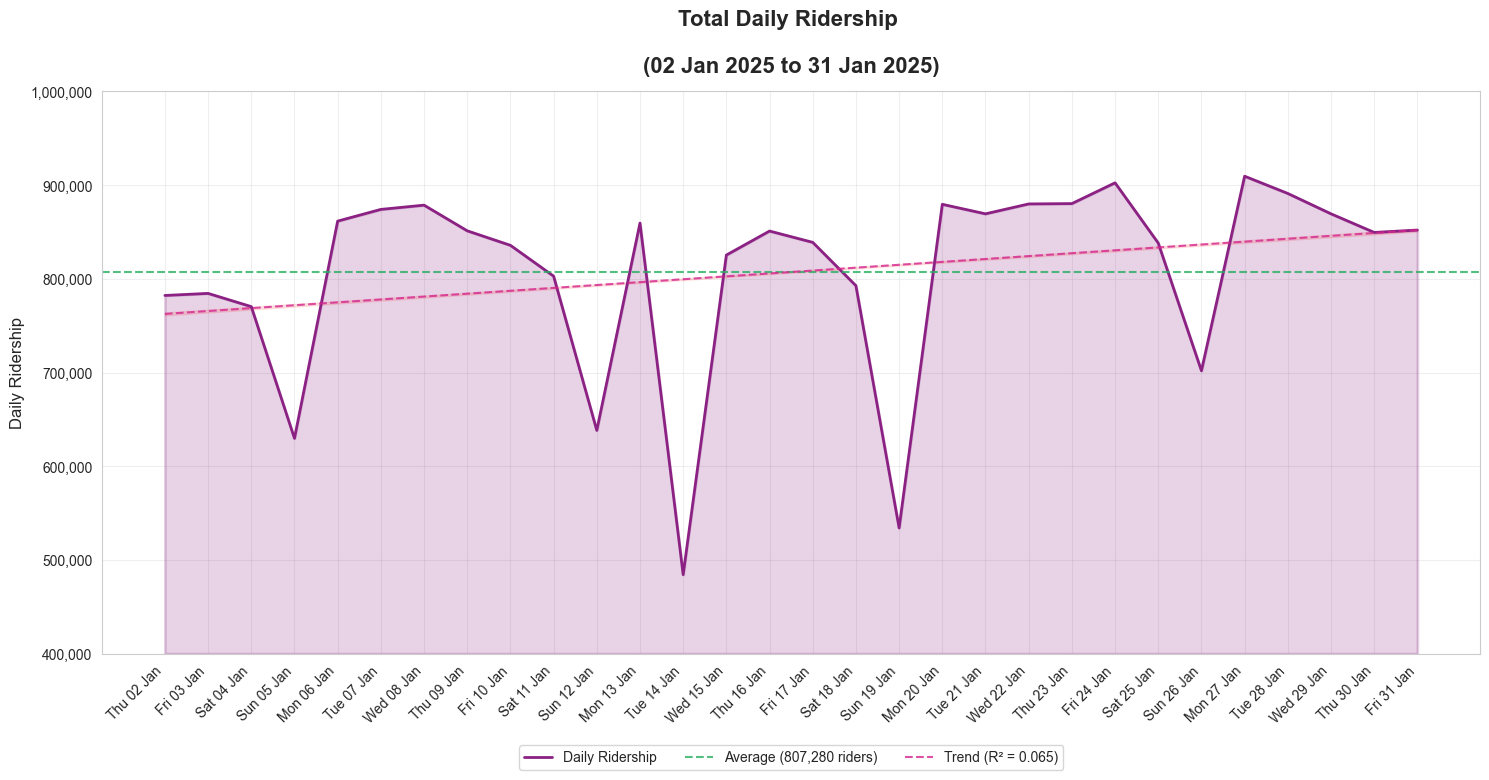

In [97]:
# yesterday = (pd.Timestamp.today() - pd.Timedelta(days=1)).strftime('%Y-%m-%d')
plot_this_df = trimmed_df(df2, number_of_days=31, end_date='2025-01-31', weekly_average=weekly_average)
ax = plot_ridership_trend(plot_this_df, base_value=400000)

**📘 Notes**
 
1. **Weekly Pattern:** The plot reveals strong weekly cycles. Each weekend dip is followed by a sharp recovery, demonstrating the metro's vital role in weekday commuting.

2. **Trend Significance:** While the trend line may suggest a slight increase or decrease in ridership, this pattern is too weak for meaningful forecasting. (See R² reference table below)

3. **Further Analysis:** The high variability in aggregate data suggests we should segment our analysis. This may reveal patterns that are currently masked by day-to-day fluctuations.

4. **When and How:**  These two plots taken together tell a more complete story - the area chart shows "when" patterns occur while the boxplot shows "how distributed" the data is within each month.

**📘 R² Interpretation Scale** – Ranging from 0.0 to 1.0, R² is a measure of how well the regression line explains variability in ridership data.

| R² Range | Interpretation | Use Case |
|----------|---------------|-----------|
| > 0.75 | Very Strong | Highly reliable for forecasting |
| 0.50 - 0.75 | Strong | Good for general predictions |
| 0.25 - 0.50 | Moderate | Use with caution |
| 0.10 - 0.25 | Weak | Not suitable for predictions |
| ≤ 0.10 | Very Weak | Indicates random behaviour |

## 💡 A Wave Rides NammaMetro

In [ ]:
def plot_passes_trend(df, 
                      number_of_days=None, 
                      end_date=None, 
                      pass_types=['One Day Pass', 'Three Day Pass', 'Five Day Pass'],
                      ax=None,
                      significant_dates=False):
    passes_df = df.copy()
    passes_df['Record Date'] = pd.to_datetime(passes_df['Record Date'], dayfirst=True)
    number_of_days = number_of_days if number_of_days else len(passes_df) 
    end_date = pd.to_datetime(end_date) \
        if pd.to_datetime(end_date) <= passes_df['Record Date'].max() \
            else passes_df['Record Date'].max() \
                if end_date else passes_df['Record Date'].max()
    start_date = end_date - pd.Timedelta(days=number_of_days-1)
    passes_df = passes_df[(passes_df['Record Date'] >= start_date) & (passes_df['Record Date'] <= end_date)]
    passes_df['Traffic Band'] = 'Weekday'
    passes_df.loc[(passes_df['Record Date'].dt.dayofweek >= 4), 'Traffic Band'] = 'Weekend Lite'
    passes_df.loc[(passes_df['Record Date'].dt.dayofweek == 6), 'Traffic Band'] = 'Weekend'

    # Define pass types and their corresponding colors
    colors = ['#8b2183', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    traffic_bands = {
        'Monday': ('Weekday', '#e6f0ff'),
        'Tuesday': ('Weekday', '#e6f0ff'),
        'Wednesday': ('Weekday', '#e6f0ff'),
        'Thursday': ('Weekday', '#e6f0ff'),
        'Friday': ('Weekend Lite', '#ffe6e6'),
        'Saturday': ('Weekend Lite', '#ffe6e6'),
        'Sunday': ('Weekend', '#f0e6ff')}

    # Shade traffic bands
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
    else:
        fig = ax.figure
    labeled_bands = set()
    current_date = start_date
    while current_date <= end_date:
        day_name = current_date.strftime('%A')
        band, color = traffic_bands[day_name]        
        start_num = mdates.date2num(current_date)
        end_num = mdates.date2num(current_date + pd.Timedelta(days=1))
        if band not in labeled_bands:
            ax.axvspan(start_num, end_num, facecolor=color, alpha=0.7, label=band)
            labeled_bands.add(band)
        else:
            ax.axvspan(start_num, end_num, facecolor=color, alpha=0.7)
        current_date += pd.Timedelta(days=1)

    # Plot each pass type
    for i, pass_type in enumerate(pass_types):
        # Add dummy plots for legend
        ax.plot([], [], color=colors[i], linewidth=2, label=f'{pass_type} (Solid)')
        ax.plot([], [], color=colors[i], linewidth=2, linestyle='--', label=f'{pass_type} (Gaps)')

        # Calculate date differences
        passes_df['date_diff'] = passes_df['Record Date'].diff().dt.days

        # Start a new segment when diff > 1
        passes_df['segment'] = (passes_df['date_diff'] > 1).cumsum()

        # Plot each segment
        for segment in passes_df['segment'].unique():
            segment_data = passes_df[passes_df['segment'] == segment]
            
            # Plot solid line for the segment
            if len(segment_data) > 0:
                ax.plot(segment_data['Record Date'], 
                       segment_data[pass_type],
                       color=colors[i], 
                       linewidth=2)

            # If there's a next segment, plot dashed line between segments
            next_segment = segment + 1
            if next_segment in passes_df['segment'].unique():
                next_segment_data = passes_df[passes_df['segment'] == next_segment]
                if len(next_segment_data) > 0:
                    # Plot dashed line between segments
                    ax.plot([segment_data['Record Date'].iloc[-1], 
                            next_segment_data['Record Date'].iloc[0]],
                           [segment_data[pass_type].iloc[-1], 
                            next_segment_data[pass_type].iloc[0]],
                           color=colors[i], 
                           linewidth=2, 
                           linestyle='--')

    # Add significant dates
    if significant_dates:
        try:
            significant_dates_df = pd.read_csv('/kaggle/input/significant-dates-in-bangalore-india/significant_dates.csv')
            significant_dates_df['Date'] = pd.to_datetime(significant_dates_df['Date'], format='%Y-%m-%d')
            
            # Get y-axis limits for text positioning
            y_min, y_max = ax.get_ylim()
            text_positions = np.linspace(y_max*0.3, y_max*0.7, len(significant_dates_df))
            
            for idx, (_, row) in enumerate(significant_dates_df.iterrows()):
                date = row['Date']
                event = row['Event']
                if start_date <= date <= end_date:
                    date_num = mdates.date2num(date)
                    ax.axvline(date_num, color='#FF6B6B', linestyle='--', linewidth=1, alpha=0.7)
                    
                    # Position text at different heights to avoid overlap
                    ax.text(date_num, text_positions[idx], event, 
                           rotation=90, 
                           verticalalignment='bottom',
                           horizontalalignment='right',
                           color='#FF6B6B',
                           fontsize=12,
                           fontweight='bold',
                           alpha=0.8,
                           bbox=dict(facecolor='white', 
                                   edgecolor='none',
                                   alpha=0.7,
                                   pad=2))
        except FileNotFoundError:
            print("significant_dates.csv not found. Skipping significant dates annotation.")

    # Format the plot
    metrics_text = 'Multiple Metrics' if len(pass_types) > 2 else ' vs '.join(pass_types)
    title = f"{metrics_text} Usage Trend\n({start_date.strftime('%d %b %Y')} to {end_date.strftime('%d %b %Y')})"
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    x_min = passes_df['Record Date'].min() - pd.Timedelta(days=0.5)
    x_max = passes_df['Record Date'].max() + pd.Timedelta(days=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(passes_df['Record Date'])
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('', fontsize=12)
    plt.ylabel('', fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Remove duplicate band labels
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), fontsize=10)
    plt.tight_layout()
    if ax is None:
        plt.show()
        return fig, ax
    else:
        return None, None

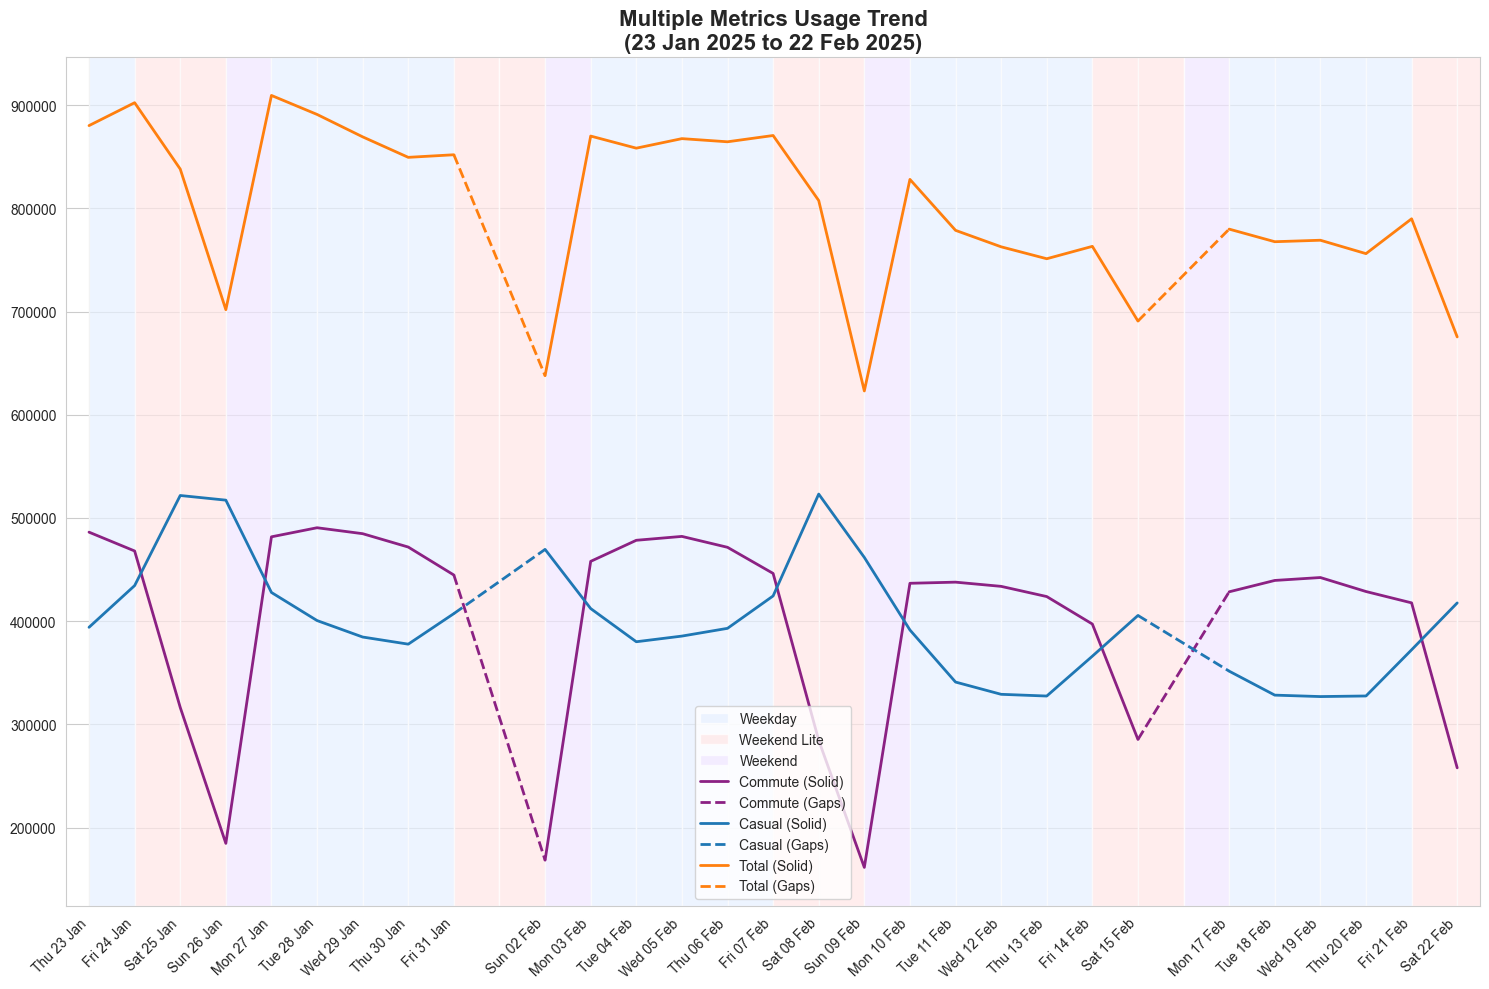

In [99]:
end_date = '2025-02-22'
number_of_days = 31
pass_types = ['Commute', 'Casual', 'Total']

ax = plot_passes_trend(df2, 
                    number_of_days=number_of_days, 
                    end_date=end_date, 
                    pass_types=pass_types)

**📘 Notes**

1. This visualisation shows a striking **inverse relationship between commuter and casual users** thus reinforcing a key finding about the dual nature of the metro system.

2. Having the total ridership line (orange) shows how the two user segments combine to create a more stable overall pattern despite their individual volatility.

3. The visualisation shows data gaps with dashed lines, maintaining data integrity while still allowing for trend analysis.

_____
# **6. The Long Weekend and Other Phenomena**

<div style="text-align: center; margin: 20px"><img src="https://github.com/thecont1/namma-metro-ridership-tracker/blob/main/images/photo_DSF2070.jpg?raw=true" style="border: 0.5px solid black; max-width: 75%; height: auto; box-shadow: 5px 5px 0px #ab66a3" alt="Sankranti Day at Gandhi Bazaar. National College Metro Station (Green Line)" /></div>

<center>
Sankranti Day at Gandhi Bazaar <code>Ⓜ️ National College</code> 🟢 Green Line<br><br>
<small><i>&copy; 2024 Mahesh Shantaram. All Rights Reserved.<i></small>
</center>

## Sankranti and Something Else

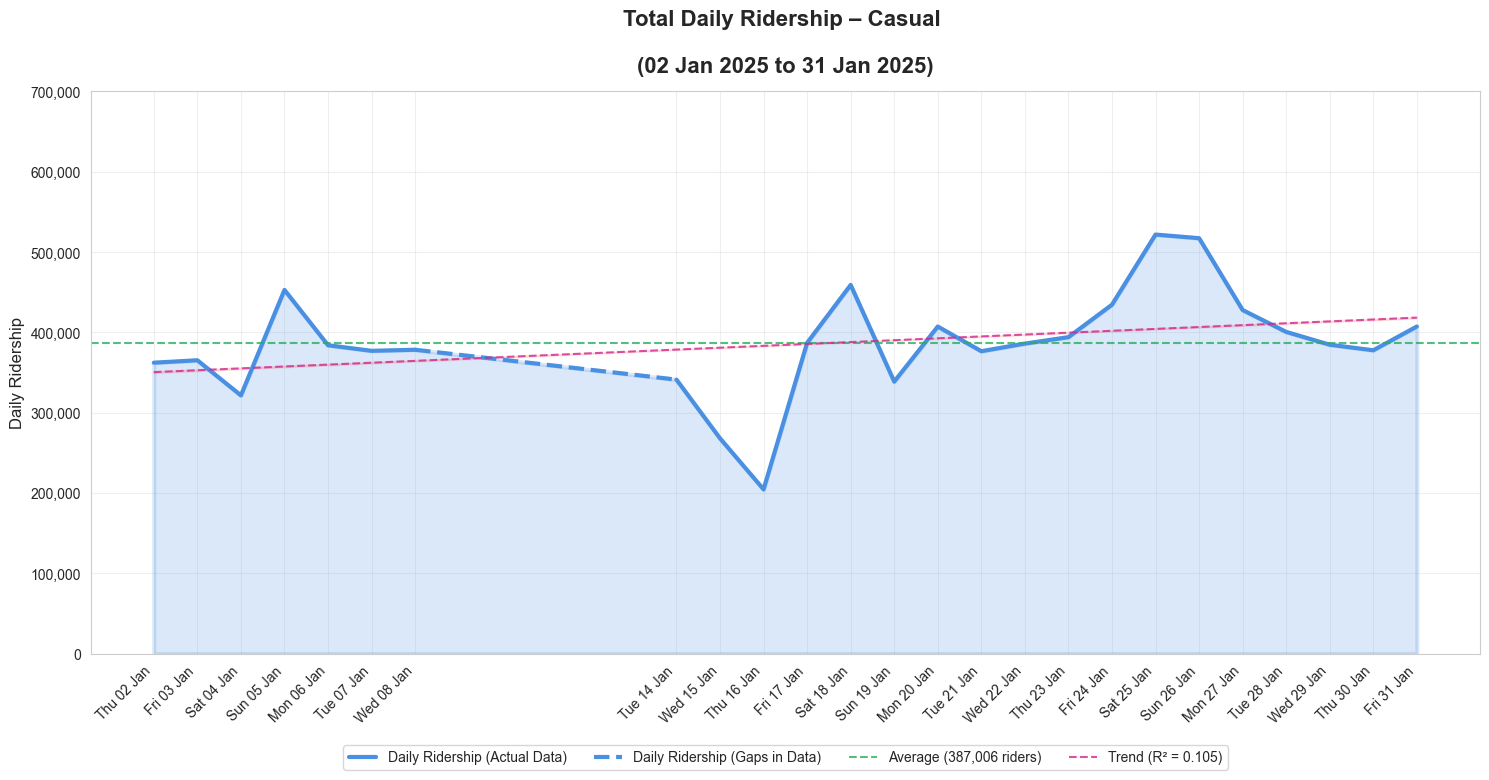

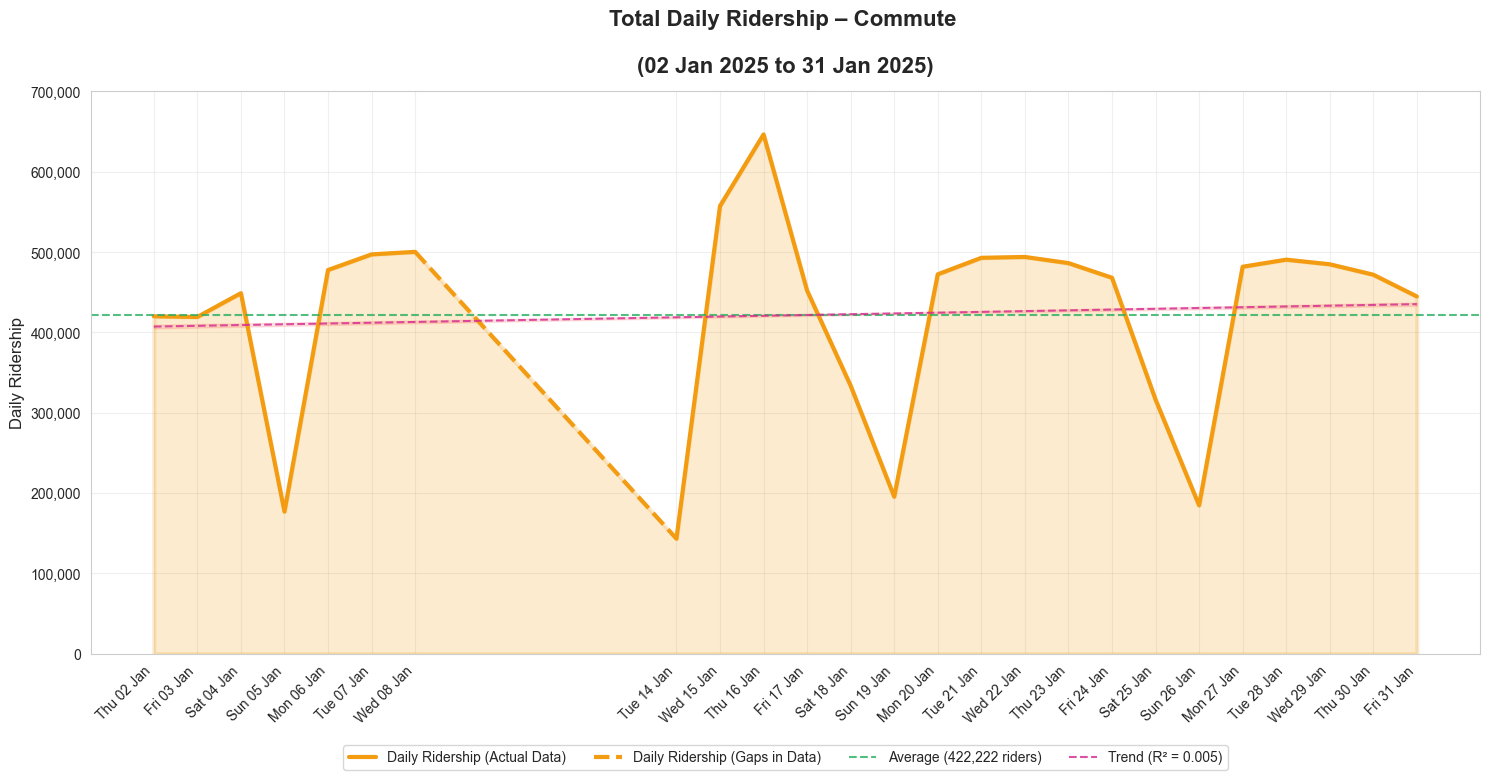

In [100]:
plot_this_df = trimmed_df(df2, number_of_days=31, end_date='2025-01-31')
ax = plot_ridership_trend(plot_this_df, traffic_band='all', user_type='Casual')
ax = plot_ridership_trend(plot_this_df, traffic_band='all', user_type='Commute')

📘 **Notes**

Holidays and cultural events have dramatically different impacts on different user segments. The separate but complementary views of Commute and Casual ridership (seen above) expose patterns that would be completely hidden in the aggregate data.

1. **Inverse Relationship:** The separate ridership trends for Casual and Commute users confirm a pattern we’ve observed before: when Commuters drop, Casual riders rise. However, there are moments—like Sankranti—when this balance breaks down.

2. **Data Gap Handling:** Dashed lines indicate gaps in data collection. Showing these explicitly rather than interpolating them maintains data integrity.

3. **January 14: The Sankranti Effect**
>
> - The festival caused a sharp drop in Commuters, as many left Bangalore to visit their hometowns.
>
> - Unlike regular weekends, Casual ridership did not increase to compensate—suggesting an overall citywide slowdown.
>
> - Compounding the disruption, Sankranti fell on a Tuesday, leading to an extended long weekend effect.
>
> 👉 Unfortunately, the data gap from Jan 13–17 prevents us from fully seeing this play out. It seems our data collector at NammaMetro also took a long weekend!

4.	**Casual Ridership Growth vs. Commuter Stability:** R² = 0.105 indicates steady growth in Casual ridership, while the Commuter trend (R² = 0.005) remains largely flat. This hints at broader behavioral shifts—possibly an **increase in tourism or recreational metro usage**.

5. **Weekend Pattern Clarity:** The weekend dips in Commute ridership are more pronounced than the corresponding peaks in Casual ridership, explaining why the total ridership still shows net dips on weekends despite the casual user increase.

<big>🤔 What remains now is to explain the less obvious bump in **Commuter traffic on Jan 15-16** and **Casual riders on Jan 25**.</big>

## Ridership Towers – Users and Payments

In [101]:
def plot_stacked_ridership(df, stack_by='user', traffic_band='all', base_value=0, ax=None):
    """
    Plot stacked histogram of ridership data.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame in df2 format with Record Date, Traffic Band, Commute, Casual columns
    stack_by : str, optional
        What to stack by: 'user' (Commute/Casual) or 'payment' (Smart Cards/Tokens/etc)
        (default: 'user')
    traffic_band : str, optional
        Filter for traffic type: 'all', 'Weekday', 'Weekend Lite', 'Weekend' (default: 'all')
    base_value : int, optional
        Base value for the y-axis (default: 0)
    ax : matplotlib.axes._axes.Axes, optional
        Axes object to plot on. If None, a new figure and axes will be created.
    """
    data = df.copy()

    if traffic_band != 'all':
        data = data[data['Traffic Band'] == traffic_band]    
    if len(data) == 0:
        print(f"No data available after applying filters")
        return None, None
    data = data.sort_values('Record Date').reset_index(drop=True)
    start_date = data['Record Date'].min()
    end_date = data['Record Date'].max()
    number_of_days = len(data)

    if stack_by == 'user':
        value_vars = ['Casual', 'Commute']
        palette = ['#8fc0ee', '#ffd690']
        title_prefix = 'User Type'
    elif stack_by == 'payment':
        value_vars = ['Group Ticket', 'QR', 'Tokens', 'NCMC', 'Smart Cards']
        palette = 'rocket_r'
        title_prefix = 'Payment Method'
    else:
        raise ValueError("stack_by must be either 'user' or 'payment'")

    # If ax is not provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,10))
    else:
        fig = ax.figure  # Get the figure from the provided axes

    melted_data = data.melt(
        id_vars=['Record Date', 'is_imputed'],
        value_vars=value_vars,
        var_name=title_prefix,
        value_name='Count')    
    sns.histplot(data=melted_data, 
                x='Record Date',
                weights='Count',
                bins=number_of_days,
                hue=title_prefix,
                multiple='stack',
                element='step',
                palette=palette,
                legend=True,
                common_norm=True,
                stat='count',
                linewidth=0.8,
                alpha=0.7,
                discrete=True,
                kde=False,
                edgecolor='black',
                ax=ax)

    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('', fontsize=14)
    ax.grid(axis='x', alpha=0.5)
    ax.set_title(f"Total Daily Ridership by {title_prefix}\n\n({start_date.strftime('%d %b %Y')} to {end_date.strftime('%d %b %Y')})", 
              fontsize=16, y=1.02, fontweight='bold')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    ax.set_xticks(data['Record Date'])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    plt.xticks(rotation=45, ha='right', fontsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

    date_series = pd.Series(data['Record Date'])
    date_gaps = date_series.diff() > pd.Timedelta(days=1)
    gap_indices = date_gaps[date_gaps].index.tolist()    
    if len(gap_indices) > 0:
        marker_y = data['Total'].max() * 1.02
        for idx in gap_indices:
            ax.axvline(x=data.loc[idx-1, 'Record Date'], color='gray', 
                       linestyle='--', alpha=0.5, linewidth=1)

    imputed_dates = data[data['is_imputed']]['Record Date']
    if len(imputed_dates) > 0:
        marker_y = data['Total'].max() * 1.02
        ax.plot(imputed_dates, [marker_y] * len(imputed_dates), 
                'k*', markersize=8, alpha=0.7, label='Imputed Data')
        ax.text(0.02, 0.98, '* Imputed from weekly averages', 
                transform=ax.transAxes, 
                fontsize=10, 
                verticalalignment='top')

    ax.set_ylim(bottom=base_value)
    plt.tight_layout()

    if ax is None:
        plt.show()
        return fig, ax  # Return fig and ax when creating a new plot
    else:
        return None, None  # Return None, None when using an existing ax

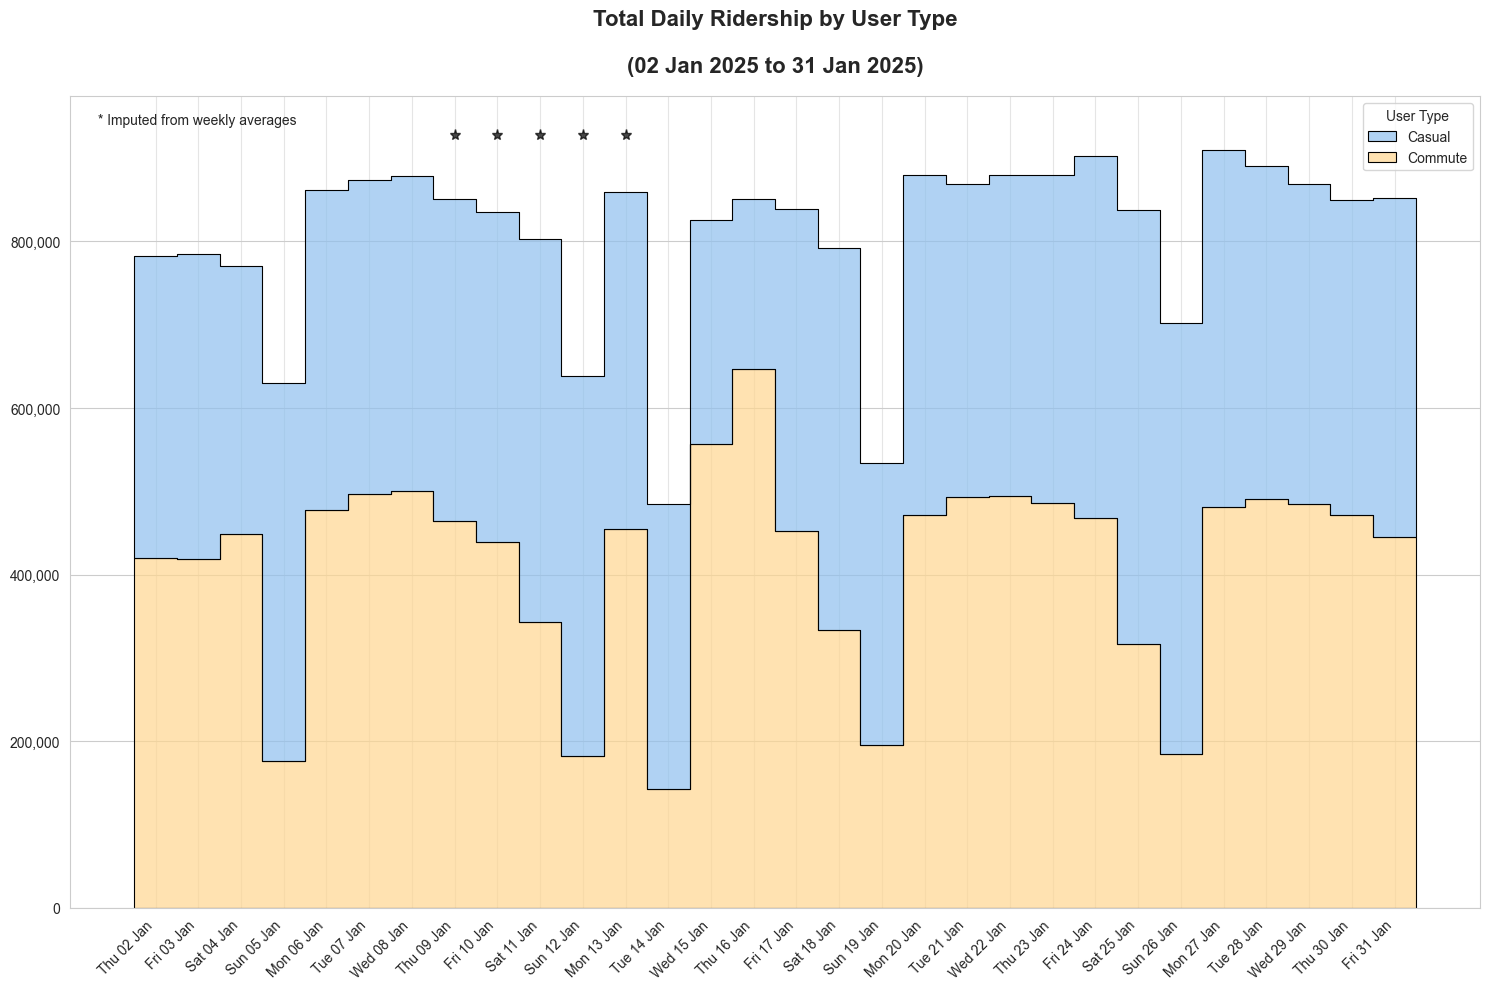

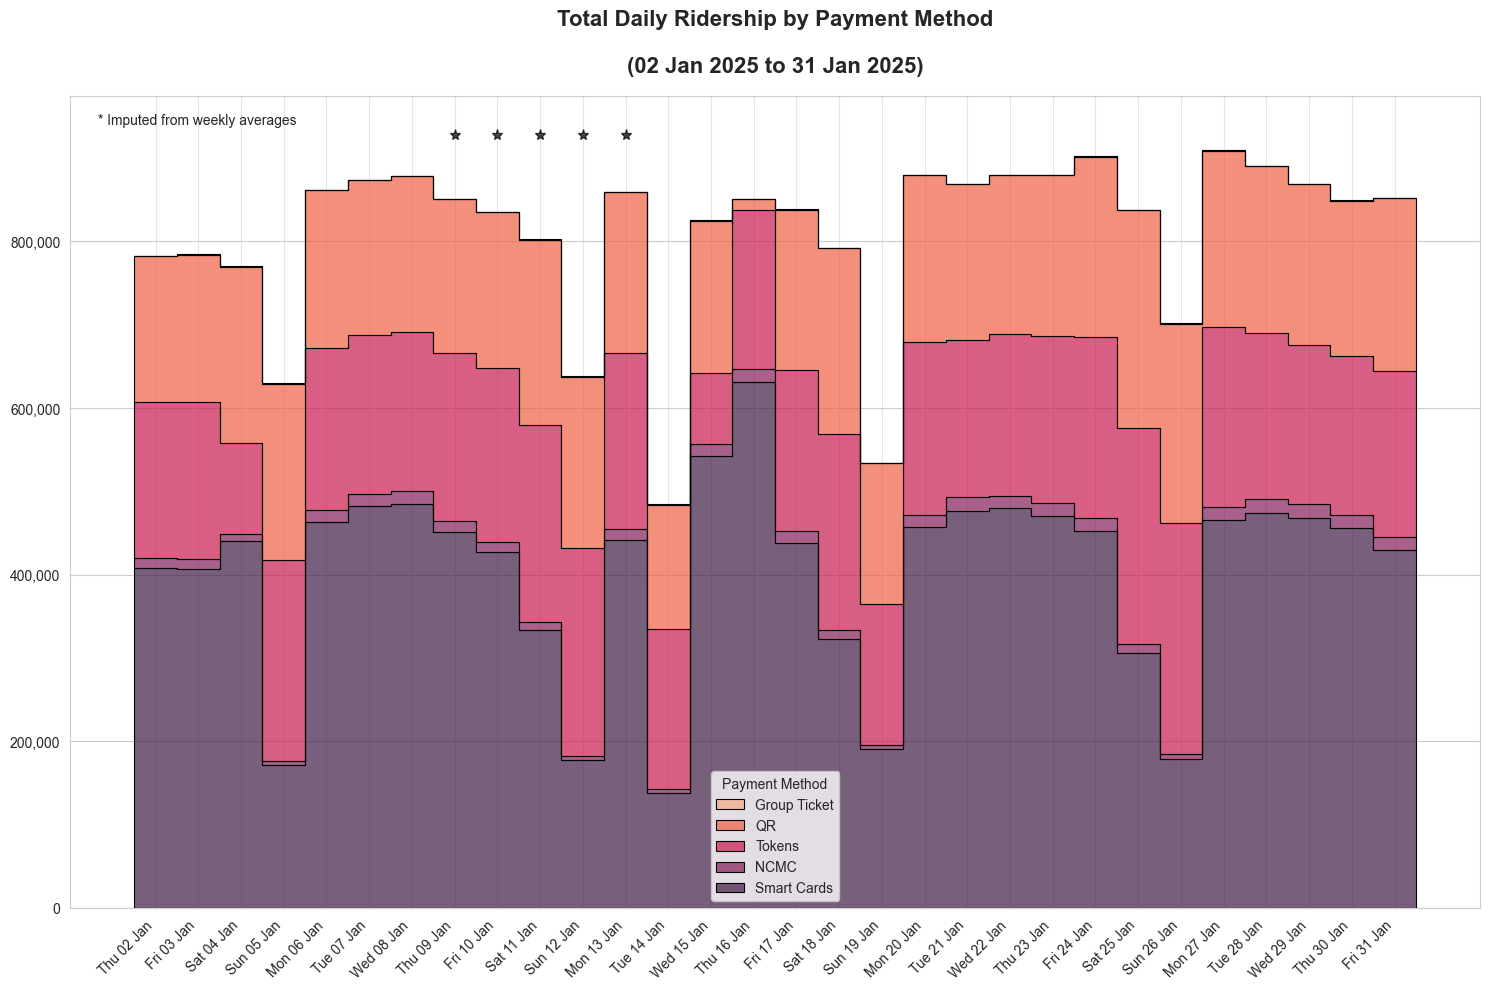

In [102]:
plot_this_df = trimmed_df(df2, number_of_days=31, end_date='2025-01-31', weekly_average=weekly_average)

ax = plot_stacked_ridership(plot_this_df, stack_by='user', traffic_band='all')
ax = plot_stacked_ridership(plot_this_df, stack_by='payment', traffic_band='all')

📘 **Notes**

1. These plots visualise the **scale of metro operations** (serving hundreds of thousands daily) and the **relative popularity of different payment options** while also highlighting the **strong weekly seasonality in urban transit usage**.

2. The asterisks at the top of the chart (indicating imputed data) also highlight how data collection gaps can impact analysis - particularly unfortunate during the Sankranti period when we might have seen interesting cultural patterns.

3. These visualisations effectively demonstrate how the metro serves dual purposes as both essential infrastructure for commuters and as a convenience for casual/leisure travelers, with the balance shifting dramatically throughout the week.

## 💡 **January 15-16 Anomaly** 

> Hidden beneath a rather normal-looking Thursday ridership, we see the shrinkage in QR+Tokens ("Casual") is compensated by a boost in Smart Card+NCMC ("Commute").  
> 
> Upon closer observation, we see that QR payments were close to zero, indicating possible system disruption. Consequently, it appears that disappointed users have opted for Smart Cards to get on with their day.

_____
# **7. Metro Enables the Visitor Economy**

<div style="text-align: center; margin: 20px"><img src="https://github.com/thecont1/namma-metro-ridership-tracker/blob/main/images/photo_MS202303-DerSpiegel1047.jpg?raw=true" style="border: 0.5px solid black; max-width: 75%; height: auto; box-shadow: 5px 5px 0px #ff3030" alt="Fans queue up outside Chinnaswamy Stadium before the start of an IPL match. Cubbon Park (Purple Line)" /></div>

<center>
Fans queue up outside Chinnaswamy Stadium before the start of an IPL match <code>Ⓜ️ Cubbon Park</code> 🟣 Purple Line<br><br>
<small><i>&copy; 2023 Mahesh Shantaram. All Rights Reserved.<i></small>
</center>

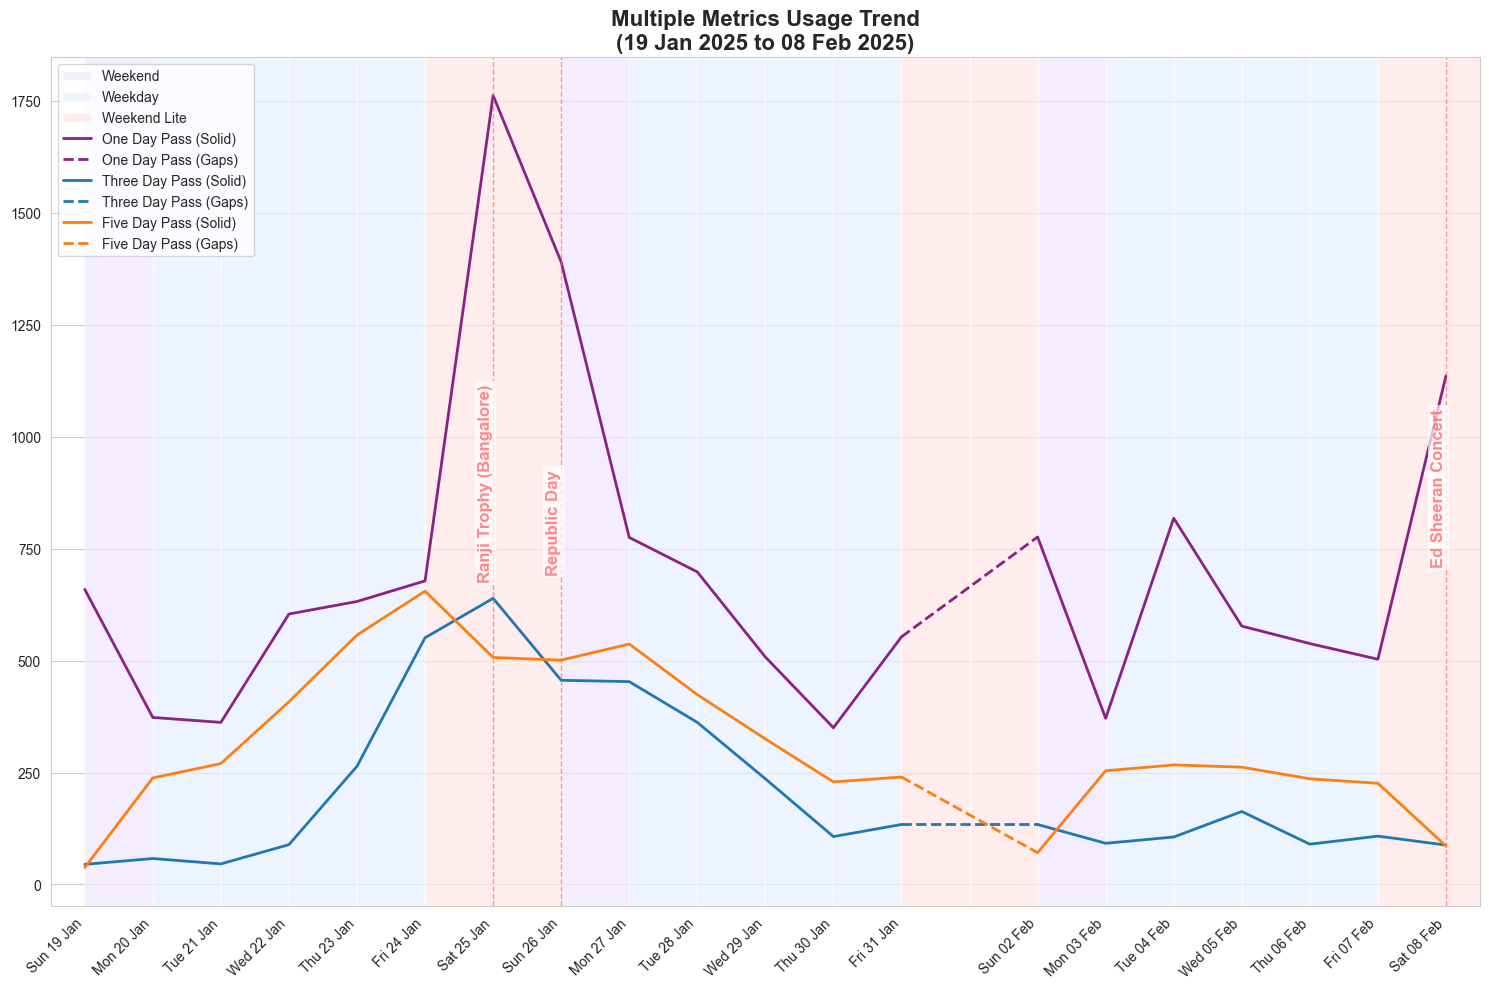

In [114]:
end_date = '2025-02-08'
number_of_days = 7*3
pass_types = ['One Day Pass', 'Three Day Pass', 'Five Day Pass']

ax = plot_passes_trend(df, 
                number_of_days=number_of_days, 
                end_date=end_date, 
                pass_types=pass_types,
                significant_dates=True)

### **The Visitor Economy** 

> Bangalore is a rising destination for major sporting and entertainment events, and the city's public and private infrastructure is constantly being upgraded to support these industries. On **Jan 25**, Karnataka played (and won!) against Punjab in the <span style="background: yellow">Ranji Trophy at Bangalore's (metro-accessible) Chinnaswamy Stadium</span>. A couple of weeks later, <span style="background: yellow">Ed Sheeran enthralled audiences at the (metro-accessible) NICE Grounds</span>. 
> 
> The spike in 1/3/5 day passes suggests that the city welcomed many out-of-state sports fans who made a holiday out of their trip. Increased footfall often translates to higher spending in hospitality sectors. This visualization provides evidence for the theory about the economic ripple effects of major events.
> 
> - **Dramatic One-Day Pass Spike:** The surge to ~1,750 One-Day Passes (more than double the typical volume) clearly indicates an influx of visitors specifically for the Ranji Trophy final. This surge is a classic marker of event-driven tourism.
>
> - **Multi-Day Pass Increases:** The concurrent rises in Three-Day and Five-Day Passes suggest that a significant portion of visitors planned extended stays in Bangalore beyond just match day - exactly what you'd expect from out-of-state sports tourists making a holiday of their trip.
> 
> - **Sustained Elevated Levels:** The elevated pass levels continuing through January 26-27 (though declining) indicate these visitors stayed in the city after the match concluded, likely contributing to weekend hospitality revenue.
> 
> - **Pre-event Arrivals:** The different pass types show distinct patterns - One-Day Passes spike dramatically on the event day itself, while Three-Day and Five-Day Passes show a more gradual build-up starting around January 23-24, suggesting pre-event arrivals.
> 
> <big>This data quantifies how major events contribute to Bangalore’s visitor economy. The metro pass sales act as a **real-time proxy for tourist activity**, showing how sports and entertainment events shape urban movement patterns. 
> 
> Beyond just moving people, the metro facilitates economic flows, reinforcing its role in city planning and development.</big>

_____
# **8. Fare Hike of February 2025 – Impact Analysis**

<div style="text-align: center; margin: 20px"><img src="https://github.com/thecont1/namma-metro-ridership-tracker/blob/main/images/photo_MS202303-DerSpiegel0259.jpg?raw=true" style="border: 0.5px solid black; max-width: 75%; height: auto; box-shadow: 5px 5px 0px #ff8c00" alt="The public gather to catch a glimpse of the Prime Minister who was in the city to inaugurate the under-construction Whitefield segment of the Purple Line and the National Common Mobility Card (NCMC). Whitefield (Kadugodi) Metro Terminus (Purple Line)" /></div>

<center>
People gather to catch a glimpse of the Prime Minister who was in the city to inaugurate the under-construction<br> <code>Ⓜ️ Whitefield (Kadugodi) Metro Terminus</code> 🟣 Purple Line and the National Common Mobility Card (NCMC).<br><br>
<small><i>&copy; 2023 Mahesh Shantaram. All Rights Reserved.<i></small>
</center>

## 💡 **Did commuters abandon NammaMetro in the days following the fare hike?**
> 
> Following recommendations of a fare fixation committee, BMRCL revised its fares for the first time since 2017. The new fares took effect on [February 9, 2025](https://www.thehindu.com/news/cities/bangalore/after-bus-fare-hike-bengalureans-will-now-have-to-shell-out-more-for-namma-metro-rides-from-feb-9/article69196596.ece).
> 
> The decision proved to be hugely unpopular with regular metro users, rudely surprising many commuters at the turnstiles on Monday morning, as well as public transportation activists. 
> 
> The fare increase far exceeded initial projections, and following a public backlash, the maximum fare increase was later [capped at 71.43%](https://www.thenewsminute.com/karnataka/karnatakabengaluru-metro-fare-hike-capped-at-71-what-does-it-mean)). Still too high. 
> 
>The media caught onto the public sentiment and variously reported a drop in daily ridership between 40,000 and 100,000 ([13% by one account](https://timesofindia.indiatimes.com/city/bengaluru/fare-hike-effect-13-drop-in-daily-ridership-on-namma-metro/articleshow/118672856.cms)). 
> 
> So, did commuters truly abandon the metro in protest, or were other factors at play? Let’s turn to statistical data analysis to separate perception from reality.

### **Did it hurt?**

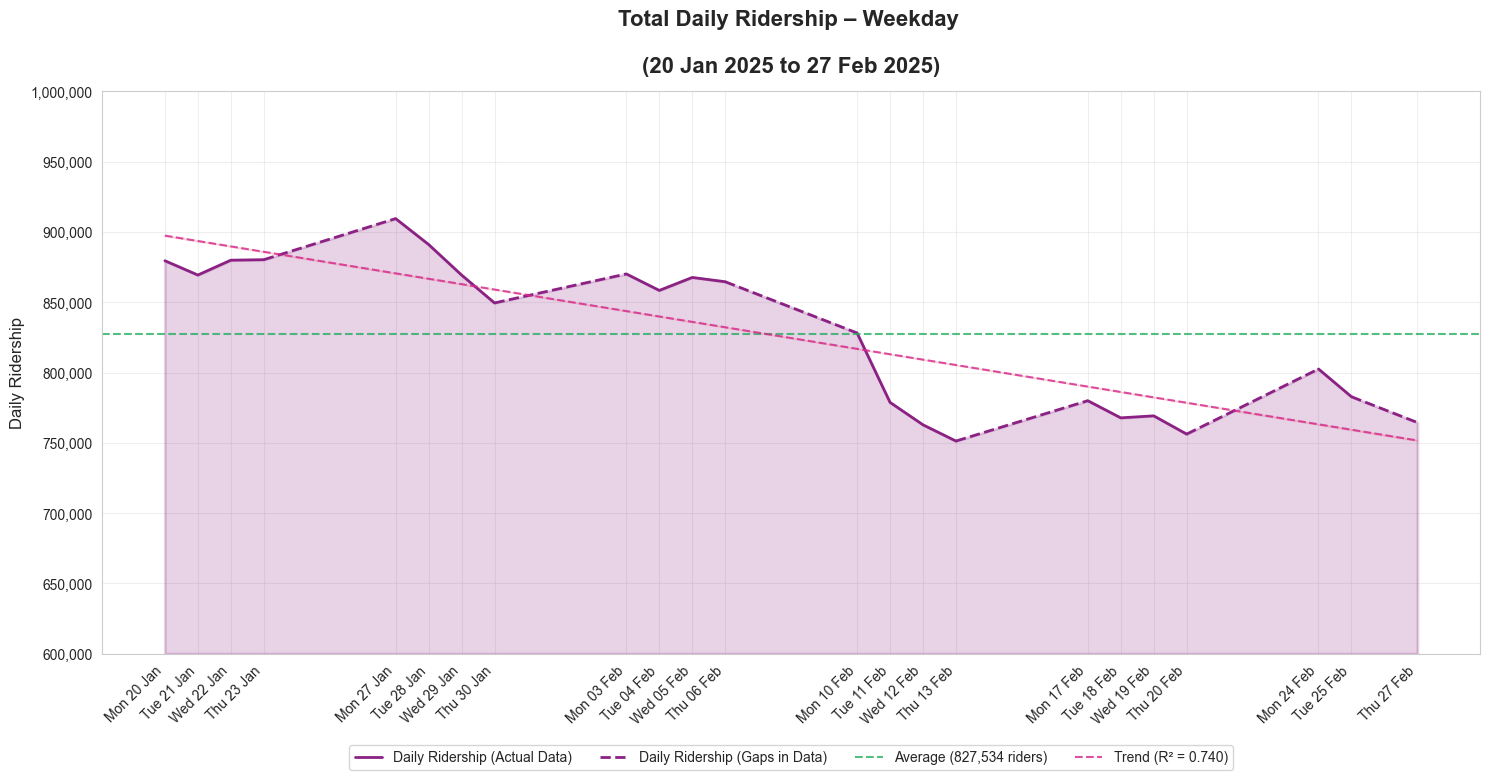

In [104]:
# Get data for a period three weeks before and after the Feb 9 fare hike
transition_df = trimmed_df(df2, 
                    end_date='2025-02-28', 
                    number_of_days=7*6, 
                    exclude_dates=['2025-01-14', '2025-01-15', '2025-01-16', 
                                   '2025-02-26'])    # Exclude Sankranti, Mahashivaratri

# Look at overall impact
ax = plot_ridership_trend(transition_df, traffic_band='Weekday', base_value=600000)

To assess the immediate impact of the fare hike, we analyzed ridership trends over a **six-week window**—three weeks before and after the fare revision on **February 9, 2025**.  

The data presents a **clear downward trend** in daily weekday ridership, with a **trendline (R² = 0.740)** indicating a strong fit.

### **After the Hike**  
 
> ✅ **Ridership decline is evident** 
> - The trendline suggests a sustained drop rather than a random fluctuation.  
> 
> ✅ **Sharp immediate fall** 
> - In the week following the fare hike, ridership plunged significantly, suggesting a strong commuter reaction.  
> 
> ✅ **Quantifiable drop**
> - In the three weeks before Feb 9, the **average weekday ridership** was **874,000 riders**.
> 
> - In the three weeks after, it fell to **777,000 riders**, an **11.1% decrease**.  
>
> ✅ **No immediate recovery** 
> - Ridership does not return to previous levels, suggesting a **short-term sustained impact**.


### **Did Aero India Play a Role?**  

> While the data confirms a downward trend, could other **confounding factors**—such as holidays, weather, or seasonal fluctuations—be at play?  
> 
> ✈️ As it turns out, **Aero India 2025**, Bangalore’s **bi-annual international air show**, took place from **Feb 10 to Feb 14**—right after the fare hike.
> 
> ✈️ **Massive footfall at an event outside Metro reach**
> 
> - On its **final day alone**, Aero India **drew over [100,000 visitors](https://english.publictv.in/aero-india-2025-over-one-lakh-visitors-witness-air-show-on-last-day/?utm_source=chatgpt.com)** to Yelahanka Airbase.  
> 
> - While official total attendance figures are unavailable, <u>past editions have exceeded a million attendees</u> over five days.  
> 
> ✈️ **Why does this matter?**
> 
> - <u>Aero India ran on all weekdays (Feb 10-14)</u>, meaning potential Metro users were commuting elsewhere.  
> 
> - The Yelahanka Airbase is not yet connected to the NammaMetro network, making it more likely attendees skipped Metro travel entirely.

<div style="text-align: center; margin-top: 40px; margin-bottom: 20px;">
<img src="https://github.com/thecont1/namma-metro-ridership-tracker/blob/main/images/photo_MS202502-AeroIndia0021.jpg?raw=true" style="border: 0.5px solid black; max-width: 75%; height: auto; box-shadow: 5px 5px 0px #9999ff" alt="Crowds watch the Sukhoi SU-57 in performance at Aero India. Yelahanka (Under Construction – Blue Line)" />
<br><br>Crowds watch the Sukhoi SU-57 in performance at Aero India <code>Ⓜ️ Yelahanka (Under Construction)</code> 🔵 Blue Line<br>
<br><small><i>&copy; 2025 Mahesh Shantaram. All Rights Reserved.<i></small>
</div>

### **Who did it hurt?**

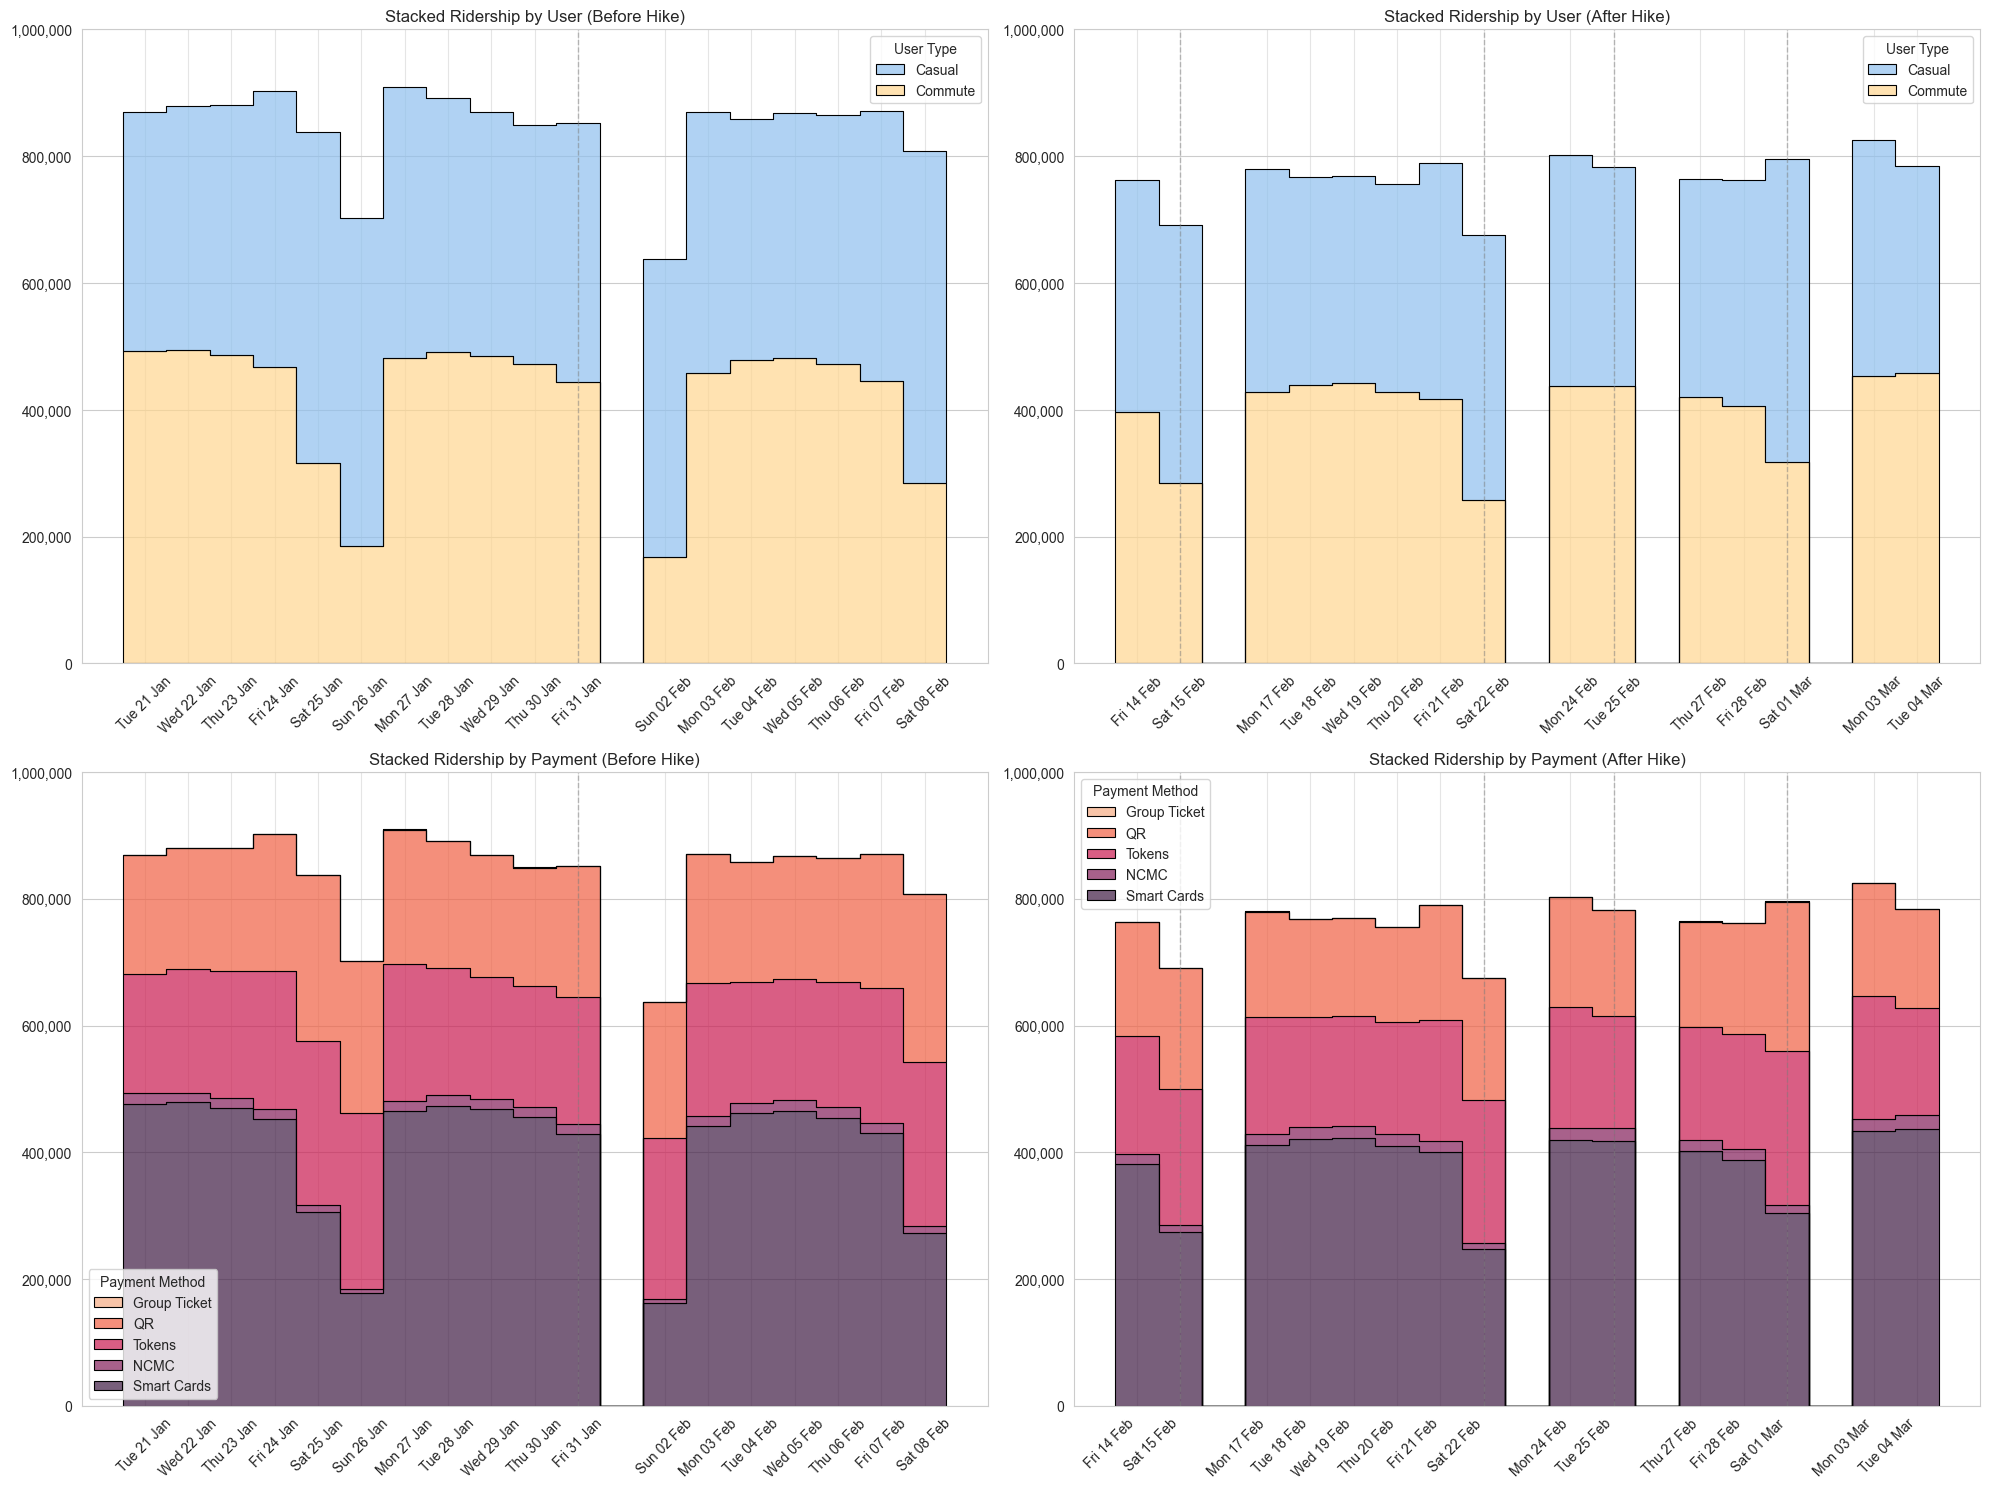

In [105]:
before_hike = trimmed_df(df2, 
                    end_date='2025-02-08', 
                    number_of_days=19, 
                    exclude_dates=['2025-01-14', '2025-01-15', '2025-01-16'])

after_hike = trimmed_df(df2, 
                    end_date='2025-03-04', 
                    number_of_days=19, 
                    exclude_dates=['2025-02-26'])

datasets = [before_hike, after_hike, before_hike, after_hike]
stack_by_options = ['user', 'user', 'payment', 'payment']

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()
for i, (dataset, stack_by) in enumerate(zip(datasets, stack_by_options)):
    ax = axes[i]
    plot_stacked_ridership(dataset, stack_by=stack_by, traffic_band='all', ax=ax)
    ax.set_title(f'Stacked Ridership by {stack_by.capitalize()} ({["Before", "After"][i%2]} Hike)')
    ax.set_ylim(top=1000000)

plt.tight_layout()
plt.show()

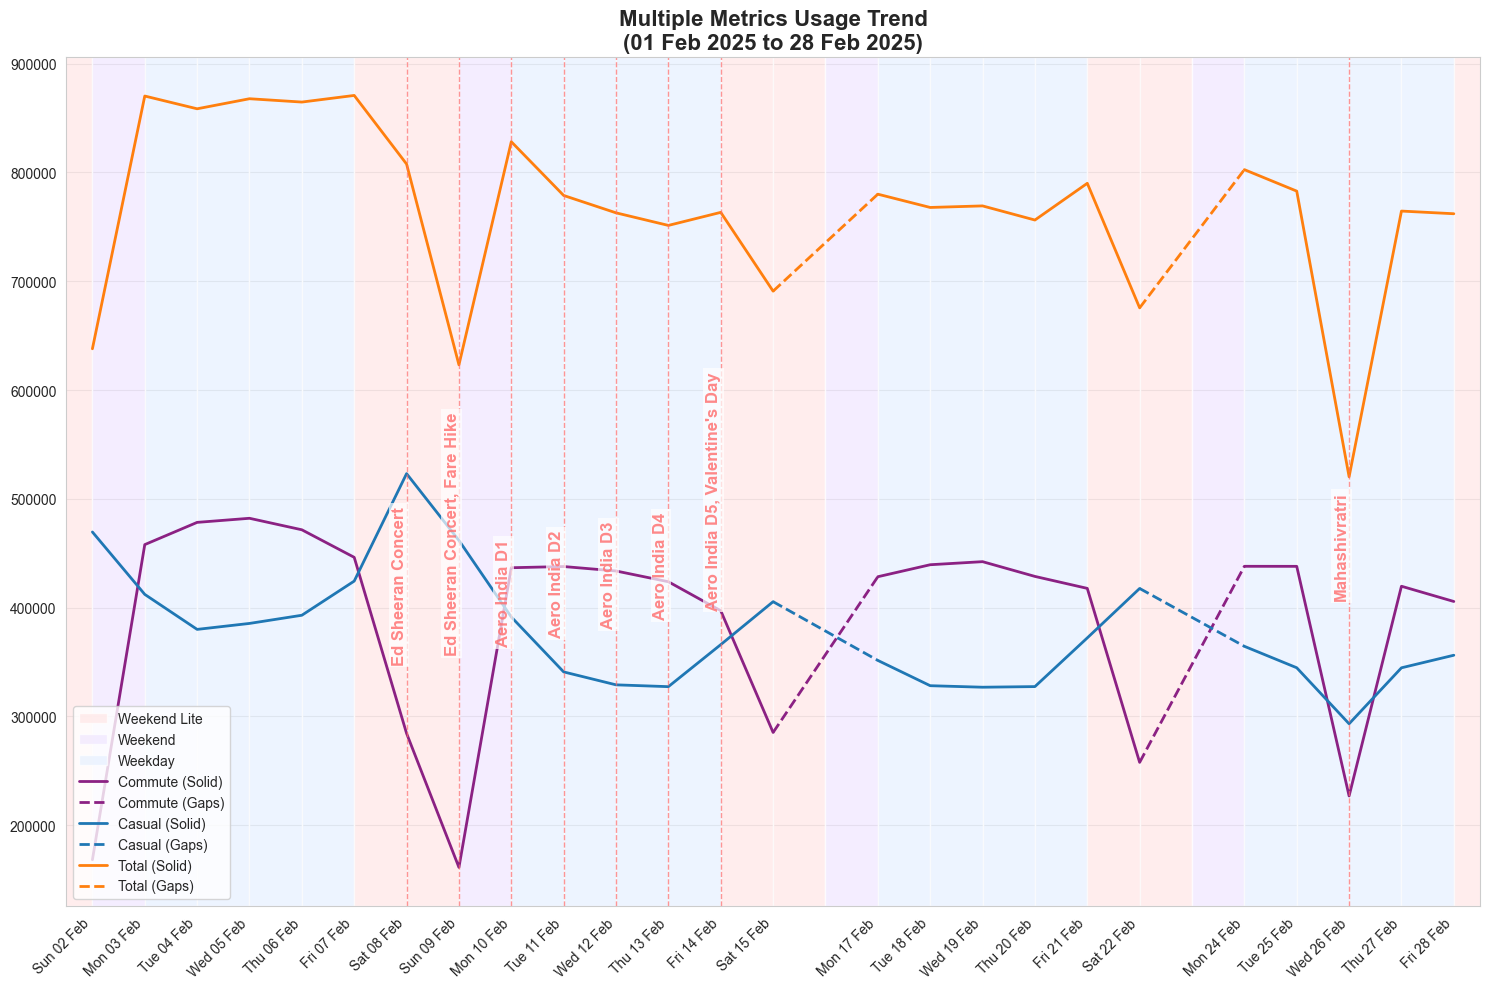

In [115]:
end_date = '2025-02-28'
number_of_days = 28
pass_types = ['Commute', 'Casual', 'Total']

ax = plot_passes_trend(df2, 
                number_of_days=number_of_days, 
                end_date=end_date, 
                pass_types=pass_types,
                significant_dates=True)

⚠️ **Commuters hit hardest**  
> 
> - The drop in weekday ridership was primarily driven by **daily commuters** who <u>reduced their Metro usage</u> more significantly than **casual riders**.
> 
> - **Casual ridership showed some resilience**, likely due to weekend trips and one-off events.  
> 
⚠️ **Payment method trends reveal a shift**  
> 
> - **Smart Card** users remain the majority, but the <u>decline in token-based payments suggests infrequent riders reduced trips</u>.  
> 
> - A **drop in QR and NCMC**-based transactions indicates a potential pullback from occasional users or tourists.
> 
⚠️ **Fare structure changes may have influenced behavior**  
> 
> - Along with the fare hike, BMRCL introduced <u>new fare rules</u>:  
> 
>   - **Smart Card & NCMC** users get a <u>5% discount</u> over token fares.  
> 
>   - During <u>off-peak hours</u> (before 8am, 12pm-4pm, after 9pm), a <u>10% discount</u> is applied.  
> 
>   - **QR payments** don’t get any discounts, potentially discouraging casual users.  
> 
> - **This may explain why QR-based transactions dropped while Smart Card usage remained stable.**  
> 
⚠️ **A closer look at trends**  
> 
> - The ridership trends are not solely explained by the fare hike—February saw major events impacting travel patterns.
> 
> - **Aero India** (Feb 10-14, 2025) likely pulled potential metro users to an area outside the network, further depressing ridership.  
> 
> - The **Ed Sheeran concerts** (Feb 9-10) fueled a final pre-hike surge**, followed by a steep drop.
> 
> - **Mahashivaratri** (Feb 26) introduced further fluctuations, particularly in casual travel.

### **How badly did it hurt?**

To quantify the impact of the fare hike, we conducted statistical hypothesis testing at a 99% confidence level for weekdays and a 95% confidence level for weekends.

In [107]:
def ttest(df_stats, variable, observed_value, alpha=0.05):
    """Perform t-test for a single observation against historical data."""
    sample_mean = df_stats.loc['mean', variable]  # Fixed indexing
    sample_std = df_stats.loc['std', variable]    # Fixed indexing
    degrees_of_freedom = df_stats.loc['count', variable] - 1

    t_stat = (observed_value - sample_mean) / (sample_std / np.sqrt(1))
    p_value = min(t.cdf(t_stat, degrees_of_freedom), t.sf(t_stat, degrees_of_freedom))

    return t_stat, p_value

def significance_test(df, weekly_average, test_date, variables=None, alpha=0.05):
    """
    Compare metrics against weekly averages and return results in markdown format.
    
    Parameters:
    -----------
    df2: DataFrame with daily ridership data
    weekly_average: DataFrame with pre-calculated weekly averages by day
    test_date: str or datetime, date to test
    variables: list of metrics to analyze
    alpha: significance level (default: 0.05)
    """
    if variables is None:
        variables = ['Smart Cards', 'NCMC', 'Tokens', 'QR', 'Group Ticket']
    
    # Convert test date to pandas datetime
    test_date = pd.to_datetime(test_date)
    day_of_week = test_date.strftime('%A')
    
    # Generate markdown header
    confidence = int((1 - alpha) * 100)
    md_output = [
        f"  ",
        f"**Test Date**: {test_date.strftime('%d %b %Y')}   ",
        f"**Baseline**: Historical {day_of_week} averages   ",
        f"**Confidence Level**: {confidence}%",
        "",
        "| Metric | Observed | Weekly Mean | Change % | t-statistic | p-value | Significant |",
        "|--------|----------|-------------|----------|-------------|----------|-------------|"
    ]
    
    # Get test date data
    test_data = df[df['Record Date'] == test_date]
    if test_data.empty:
        md_output.append(f"\n> No data found for test date: {test_date}")
        return '\n'.join(md_output)
    
    # Get same-day data for standard deviation calculation
    same_day_data = df[pd.to_datetime(df['Record Date']).dt.day_name() == day_of_week]
    
    for var in variables:
        observed_value = test_data[var].iloc[0]
        weekly_mean = weekly_average.loc[day_of_week, var]
        weekly_std = same_day_data[var].std()
        weekly_count = len(same_day_data)
        
        t_stat = (observed_value - weekly_mean) / (weekly_std / np.sqrt(1))
        p_value = min(t.cdf(t_stat, weekly_count - 1), t.sf(t_stat, weekly_count - 1))
        
        # Add row to markdown table
        significant = ('⬆︎' if t_stat > 0 else '⬇︎') if (p_value < alpha) else '🚫'
        md_output.append(
            f"| {var} | {int(observed_value):,d} | {int(weekly_mean):,d} | "
            f"{round(((observed_value / weekly_mean) - 1) * 100, 1):+.1f}% | "
            f"{t_stat:+.2f} | {p_value:.4f} | {significant} |"
        )
    
    return '\n'.join(md_output)

def analyze_payment_migration(df, weekly_average, test_date, variables=None, days_to_analyze=5):
    """
    Analyze how metrics deviate from historical patterns.
    
    Parameters:
    -----------
    df2: DataFrame with daily ridership data
    weekly_average: DataFrame with pre-calculated weekly averages by day
    test_date: str or datetime, start date of analysis period
    variables: list of metrics to analyze (default: payment methods)
    days_to_analyze: int, number of days to analyze
    """
    if variables is None:
        variables = ['Smart Cards', 'NCMC', 'Tokens', 'QR']
    
    # Get test period data
    dates = pd.date_range(start=test_date, periods=days_to_analyze, freq='D')
    test_data = df[df['Record Date'].isin(dates)].copy()
    
    if test_data.empty:
        return None, None
    
    # Add day of week and historical averages
    test_data['Day of Week'] = pd.to_datetime(test_data['Record Date']).dt.day_name()
    analysis_data = pd.DataFrame()
    
    # Calculate deviations from historical averages
    for metric in variables:
        actual = test_data.set_index('Day of Week')[metric]
        expected = weekly_average[metric]
        deviation = ((actual / expected) - 1) * 100
        analysis_data[f'{metric}_deviation'] = deviation
    
    # Compute correlation matrix of deviations
    corr_matrix = analysis_data.corr()
    
    return analysis_data, corr_matrix

def plot_payment_correlation_heatmap(corr_matrix, title=None):
    """Plot correlation heatmap of payment method deviations (lower triangle only)."""
    if corr_matrix is None:
        return None
    
    # Clean up column names for display
    display_names = {col: col.replace('_deviation', '') 
                    for col in corr_matrix.columns}
    corr_matrix = corr_matrix.rename(columns=display_names)
    corr_matrix = corr_matrix.rename(index=display_names)
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    fig, ax = plt.subplots(figsize=(10, 8))    

    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='RdYlBu_r',
                vmin=-1, vmax=1,
                center=0,
                square=True,
                cbar_kws={'label': '', 'aspect': 6},
                ax=ax)
    
    if title is None:
        title = (f"Payment Method Migration Analysis\n"
                f"Correlation of Deviations from Historical Averages")
    
    plt.title(title, fontsize=12, y=1.02, fontweight='bold')
    plt.figtext(0.05, -0.15, 
        "How to read this chart:\n" +
        "• Red: payment methods deviating together from their averages\n" +
        "• Blue: payment methods deviating in opposite directions\n" +
        "• Darker colors: stronger relationships\n" +
        "• Values range from -1 (perfect negative) to +1 (perfect positive)",
        fontsize=10, 
        bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    return fig

def analyze_event_impact(df, event_date='2025-02-09', metrics=['Smart Cards', 'NCMC', 'Tokens', 'QR', 'Commute', 'Casual'], alpha=0.05):
    """
    Compare pre and post fare hike patterns with colored traffic band output.
    """
    # Define color scheme for traffic bands
    band_colors = {
        'Weekday': '#e6f0ff',       # Light blue
        'Weekend Lite': '#ffe6e6',  # Light pink
        'Weekend': '#f0e6ff'        # Light purple
    }

    # Create pre and post datasets
    pre_hike = df[df['Record Date'] < event_date]
    post_hike = df[df['Record Date'] > event_date]
    
    # Initialize HTML table
    table_lines = [f"At {round((1 - alpha)*100, 1)}% Confidence Level:<br><table style='width: 75%; color: black'>"]
    
    # Add headers
    headers = ['Traffic Band', 'Metric', 'Pre-Event Mean', 'Post-Event Mean', 'Change %', 'CI Range', 'Significant?']
    table_lines.append("<tr style='background-color: black; color: white'><th>" + "</th><th>".join(headers) + "</th></tr>")
    
    # Process each traffic band
    for band in ['Weekday', 'Weekend Lite', 'Weekend']:
        pre_band = pre_hike[pre_hike['Traffic Band'] == band]
        post_band = post_hike[post_hike['Traffic Band'] == band]
        
        if len(pre_band) == 0 or len(post_band) == 0:
            continue
        
        # Process metrics for each band
        for metric in metrics:
            pre_mean = pre_band[metric].mean()
            pre_std = pre_band[metric].std()
            post_mean = post_band[metric].mean()
            n_samples = len(pre_band)
            
            z_score = norm.ppf(1 - alpha/2)
            pct_change = ((post_mean - pre_mean) / pre_mean) * 100
            ci = z_score * ((pre_std / pre_mean) * 100) / np.sqrt(n_samples)
            
            # Determine trend symbol
            trend = '🚫'  # Not significant
            if (pct_change - ci > 0) or (pct_change + ci < 0):
                trend = '<span style="color: green">⬆︎</sapn>' if pct_change > 0 else '<span style="color: red">⬇︎</span>'
            
            # Format row with appropriate color
            row_data = [
                band,
                metric,
                f"{int(pre_mean):,}",
                f"{int(post_mean):,}",
                f"{pct_change:+.1f}%",
                f"[{pct_change-ci:.1f}%, {pct_change+ci:.1f}%]",
                trend
            ]
            
            table_lines.append(f'<tr style="background-color: {band_colors[band]}">')
            table_lines.append("    <td>" + "</td>    <td>".join(row_data) + "</td>")
            table_lines.append("</tr>")
    
    table_lines.append("</table>")
    return " ".join(table_lines)

In [108]:
# Preparing pre-hike data for reasonably accurate comparison
# Move event date from Feb 9 to Feb 16 to avoid Aero India - the confounding factor
event_date='2025-02-16'
exclude_dates = ['2025-02-26', 
                 '2025-02-14', '2025-02-13', '2025-02-12', '2025-02-11', '2025-02-10', 
                 '2025-01-16', '2025-01-15', '2025-01-14', '2025-01-01',
                 '2024-12-25', '2024-12-24', '2024-12-31',
                 '2024-11-01', '2024-10-31']
df3 = trimmed_df(df2, number_of_days=180, end_date='2025-03-08', exclude_dates=exclude_dates, weekly_average=None)
df3 = df3[(df3['Record Date'] >= '2024-11-01') & (df3['Record Date'] <= '2025-02-28')]

df3_weekday = df3[df3['Traffic Band'] == 'Weekday']
results_md = analyze_event_impact(df3_weekday, 
                     event_date=event_date, 
                     alpha=0.01)
display(Markdown(results_md))

df3_weekend = df3[df3['Traffic Band'].isin(['Weekend Lite', 'Weekend'])]
results_md = analyze_event_impact(df3_weekend, 
                     event_date=event_date, 
                     alpha=0.05)
display(Markdown(results_md))

At 99.0% Confidence Level:<br><table style='width: 75%; color: black'> <tr style='background-color: black; color: white'><th>Traffic Band</th><th>Metric</th><th>Pre-Event Mean</th><th>Post-Event Mean</th><th>Change %</th><th>CI Range</th><th>Significant?</th></tr> <tr style="background-color: #e6f0ff">     <td>Weekday</td>    <td>Smart Cards</td>    <td>457,796</td>    <td>414,920</td>    <td>-9.4%</td>    <td>[-12.2%, -6.6%]</td>    <td><span style="color: red">⬇︎</span></td> </tr> <tr style="background-color: #e6f0ff">     <td>Weekday</td>    <td>NCMC</td>    <td>13,338</td>    <td>18,590</td>    <td>+39.4%</td>    <td>[33.0%, 45.7%]</td>    <td><span style="color: green">⬆︎</sapn></td> </tr> <tr style="background-color: #e6f0ff">     <td>Weekday</td>    <td>Tokens</td>    <td>202,258</td>    <td>179,534</td>    <td>-11.2%</td>    <td>[-13.3%, -9.2%]</td>    <td><span style="color: red">⬇︎</span></td> </tr> <tr style="background-color: #e6f0ff">     <td>Weekday</td>    <td>QR</td>    <td>186,419</td>    <td>161,071</td>    <td>-13.6%</td>    <td>[-15.8%, -11.4%]</td>    <td><span style="color: red">⬇︎</span></td> </tr> <tr style="background-color: #e6f0ff">     <td>Weekday</td>    <td>Commute</td>    <td>471,134</td>    <td>433,510</td>    <td>-8.0%</td>    <td>[-10.8%, -5.2%]</td>    <td><span style="color: red">⬇︎</span></td> </tr> <tr style="background-color: #e6f0ff">     <td>Weekday</td>    <td>Casual</td>    <td>389,195</td>    <td>341,176</td>    <td>-12.3%</td>    <td>[-14.0%, -10.7%]</td>    <td><span style="color: red">⬇︎</span></td> </tr> </table>

At 95.0% Confidence Level:<br><table style='width: 75%; color: black'> <tr style='background-color: black; color: white'><th>Traffic Band</th><th>Metric</th><th>Pre-Event Mean</th><th>Post-Event Mean</th><th>Change %</th><th>CI Range</th><th>Significant?</th></tr> <tr style="background-color: #ffe6e6">     <td>Weekend Lite</td>    <td>Smart Cards</td>    <td>365,396</td>    <td>344,836</td>    <td>-5.6%</td>    <td>[-14.4%, 3.2%]</td>    <td>🚫</td> </tr> <tr style="background-color: #ffe6e6">     <td>Weekend Lite</td>    <td>NCMC</td>    <td>10,280</td>    <td>15,578</td>    <td>+51.5%</td>    <td>[39.4%, 63.6%]</td>    <td><span style="color: green">⬆︎</sapn></td> </tr> <tr style="background-color: #ffe6e6">     <td>Weekend Lite</td>    <td>Tokens</td>    <td>223,676</td>    <td>198,715</td>    <td>-11.2%</td>    <td>[-16.8%, -5.5%]</td>    <td><span style="color: red">⬇︎</span></td> </tr> <tr style="background-color: #ffe6e6">     <td>Weekend Lite</td>    <td>QR</td>    <td>200,574</td>    <td>182,872</td>    <td>-8.8%</td>    <td>[-15.9%, -1.8%]</td>    <td><span style="color: red">⬇︎</span></td> </tr> <tr style="background-color: #ffe6e6">     <td>Weekend Lite</td>    <td>Commute</td>    <td>375,676</td>    <td>360,414</td>    <td>-4.1%</td>    <td>[-12.9%, 4.7%]</td>    <td>🚫</td> </tr> <tr style="background-color: #ffe6e6">     <td>Weekend Lite</td>    <td>Casual</td>    <td>424,937</td>    <td>382,057</td>    <td>-10.1%</td>    <td>[-15.3%, -4.9%]</td>    <td><span style="color: red">⬇︎</span></td> </tr> </table>

🛜 **NCMC Growth Amid Decline**

> - The most striking finding is that NCMC usage actually surged 🚀 39.4% (CI: +33.0% to +45.7%) across both Weekday and Weekend Lite bands while all other payment methods declined.
> 
> - This dramatic shift that suggests a deliberate migration between payment methods rather than just abandonment of the metro system.

🛜 **Smart Card Decline Severe**

> - Despite the 5-10% discount benefit, Smart Card use dropped by 9.4% (CI: -12.2% to -6.6%) 📉
> 
> - This suggests that while some users may have migrated to NCMC, others did reduce their metro usage.

🛜 **QR Disadvantaged**

> - QR-based transactions saw the steepest decline at -13.6% (CI: -15.8% to -11.4%) 📉
> 
> - Commuters (-8.0%) and casual riders (-12.3%) both cut back significantly
> 
> - This aligns with the new fare structure, which offers <u>discounts only to Smart Card and NCMC users, putting QR-based payments at a disadvantage</u>.

🛜 **Weekend riders showed more mixed behavior**

> - Token usage fell by 11.2% (CI: -13.3% to -9.2%) 📉
> 
> - Casual ridership fell by 10.1%, reinforcing the trend of non-commuter pullback
> 
> - Smart Card (-5.6%) and Commute (-4.1%) declines were NOT statistically significant 🚫

<br>

### 💡 A More Complex Story – Users Adapted

Rather than a simple &ldquo;users abandoned the metro&rdquo; story, this shows <u>a complex adaptation pattern</u> where some users changed behaviour by switching payment methods while others reduced usage. 

The statistical significance at a high confidence level of these changes confirms they represent real shifts in user behaviour and not just normal variation.

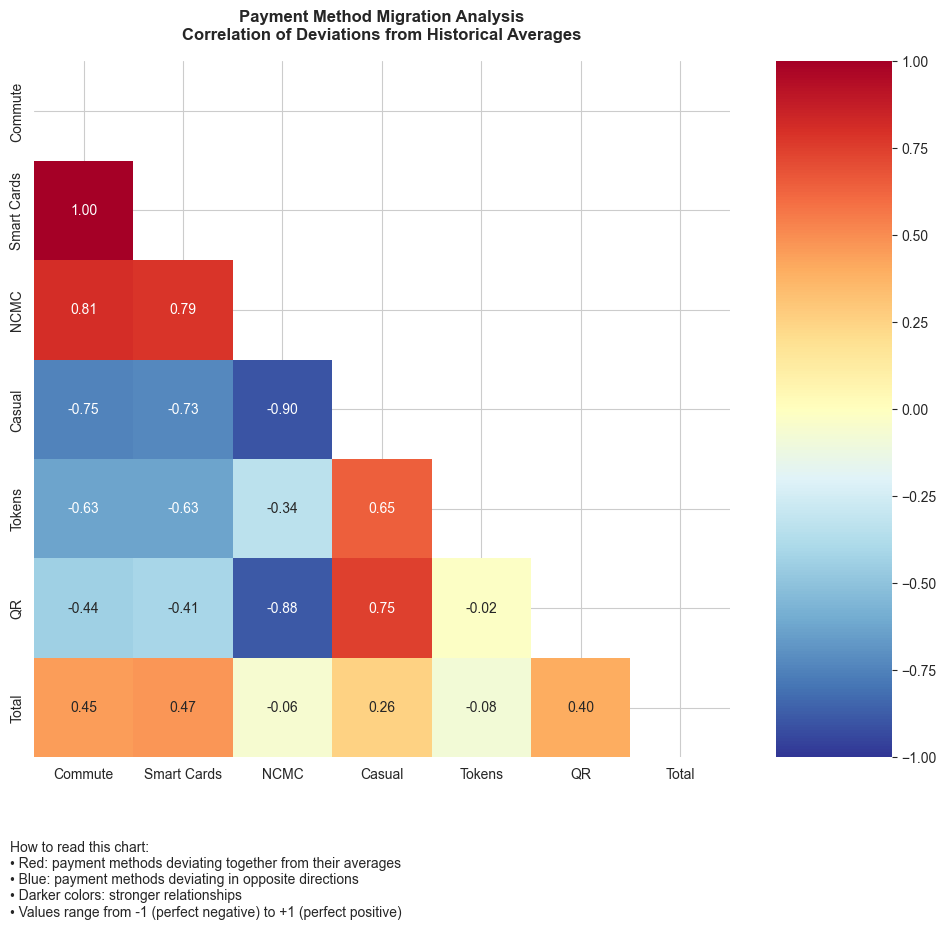

In [109]:
# Define variables to test (payment methods)
test_date = '2025-02-17'
variables = ['Commute', 'Smart Cards', 'NCMC', 'Casual', 'Tokens', 'QR', 'Total']

analysis_data, corr_matrix = analyze_payment_migration(df3, weekly_average, test_date, variables, days_to_analyze=4)
fig = plot_payment_correlation_heatmap(corr_matrix)

🛜 **NCMC Growth Amid Decline**  

> - NCMC growth has a strong positive relationship with Smart Cards (0.79) and Commute (0.81), suggesting that many **regular commuters adopted NCMC instead of abandoning metro usage entirely**.
> 
> - This indicates a deliberate migration rather than a complete drop in ridership.

🛜 **Smart Card Decline Severe**  

> The heatmap shows a strong negative correlation (-0.73) between Smart Cards and Casual ridership, reinforcing that **casual users were more likely to abandon Smart Cards entirely** rather than switch.
> 
> - While some commuters migrated to NCMC, **others did reduce their metro usage**.  

🛜 **QR Disadvantaged**

> - QR-based transactions saw the steepest decline at -13.6% (CI: -15.8% to -11.4%) 📉.
> 
> - QR usage shows a very strong negative correlation (-0.88) with NCMC, indicating that <u>QR users heavily migrated to NCMC payments</u>.  

## 🏆 The Bigger Picture: Migration vs. Abandonment  

> - While the statistical data <u>confirms significant shifts in user behaviour</u>, the heatmap reveals that <u>these shifts involved migration between payment methods rather than total abandonment</u>.
>
> - NCMC adoption appears to have come largely from former QR users, while QR’s decline aligns with a drop in casual ridership.  
> 
> - Fare policies played a direct role in shaping user behavior, as the introduction of discounts for NCMC and Smart Cards incentivized migration, while the lack of such benefits for QR payments contributed to its decline.

<div style="text-align: center;"><img src="https://github.com/thecont1/namma-metro-ridership-tracker/blob/main/images/MS202303-DerSpiegel0135.jpg?raw=true" style="border: 0.5px solid black; max-width: 75%; height: auto; box-shadow: 5px 5px 0px #ff6600" alt="Sunset at KR Pura junction. Krishnarajapura Metro Station (Purple Line)" /></div>

<center>
<br>Sunset at KR Pura junction. <code>Ⓜ️ Krishnarajapura Metro Station</code> 🟣 Purple Line
<br><br><small><i>&copy; 2023 Mahesh Shantaram. All Rights Reserved.<i></small>
</center>

_____
# **9. The Conspiracy Theory 😈**

## **The Curious Case of Jan 15-16**

> Let's start with what is plainly visible in the data.
> 
> 1. In any normal week, Smart Cards, QR, and Token payments average 450K, 190K, and 200K respectively. (See [Average Daily Ridership by Payment Method](#average-daily-ridership-by-payment-method))
> 
> 2. On **Wednesday, January 15**, when people were getting back to work after an extended Sankranti holiday, something **disrupted the Token system**, causing a sharp drop to just 90K transactions–less than half the usual. 
> 
> 3. The very next day, **Thursday, January 16**, the data shows that *all* forms of **QR payments** (via WhatsApp, Paytm, and even Metro's own QR) **collapsed to nearly zero**.  
> 
> 4. Both systems recovered instantly on consecutive days.
> 
> 5. Meanwhile, **Smart Card transactions shot up drastically**, reaching 550K on Jan 15 and an unprecedented 650K on Jan 16**—a **+200K single-day spike** like never seen before!

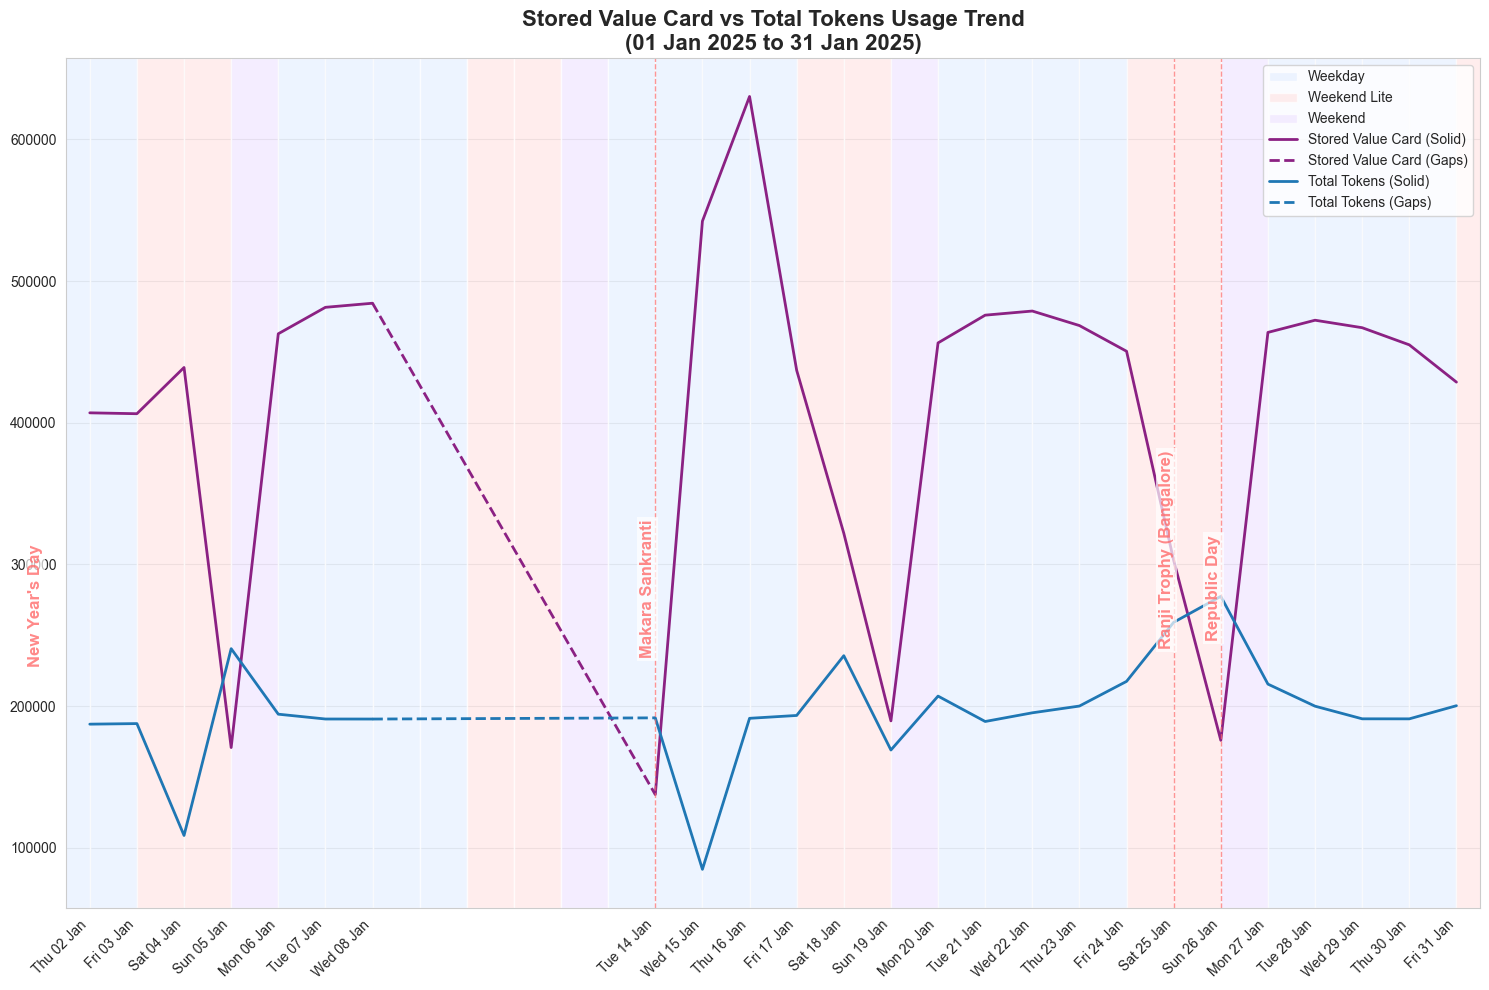

In [116]:
end_date = '2025-01-31'
number_of_days = 31
pass_types = ['Stored Value Card', 'Total Tokens']

ax = plot_passes_trend(df, 
                    number_of_days=number_of_days, 
                    end_date=end_date, 
                    pass_types=pass_types, 
                    significant_dates=True)

#### 👆🏼 Jan 15: Notice the sudden **drop in Tokens** and sharp **rise in Smart Cards**.

#### 👇🏼 Jan 16: A **collapse in QR payments** is accompanied by an **astronomical surge in Smart Cards**.

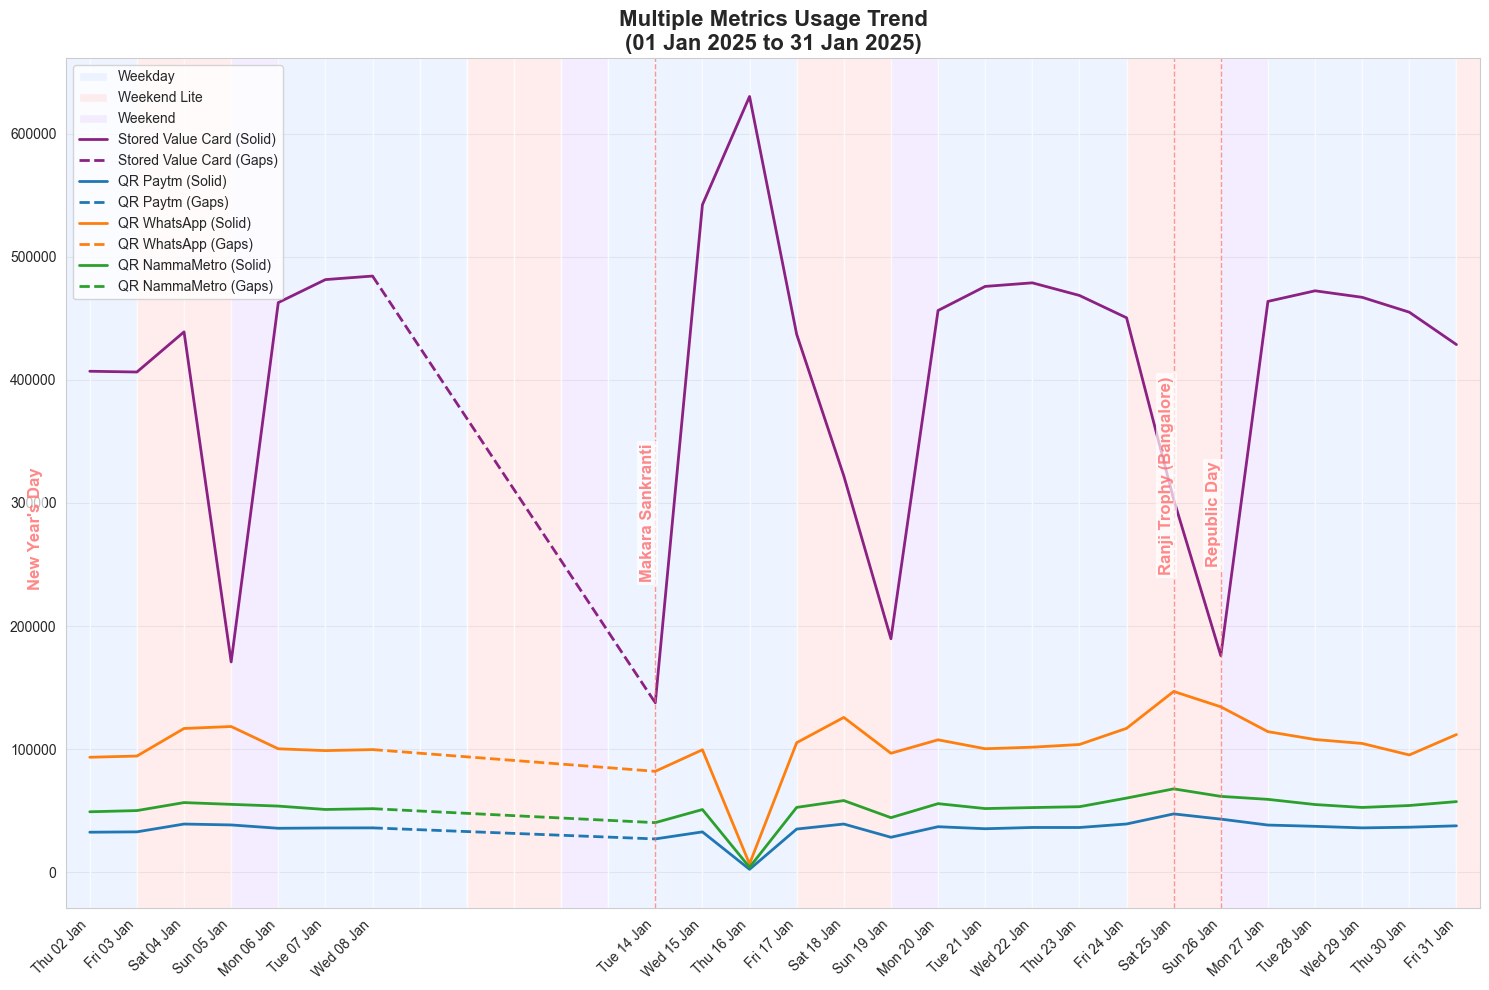

In [117]:
end_date = '2025-01-31'
number_of_days = 31
pass_types = ['Stored Value Card', 'QR Paytm', 'QR WhatsApp', 'QR NammaMetro']

ax = plot_passes_trend(df, 
                    number_of_days=number_of_days, 
                    end_date=end_date, 
                    pass_types=pass_types, 
                    significant_dates=True)

## **Payment Disruptions: Examining the Patterns**

Before drawing conclusions, let’s lay out the key observations and assumptions:

1. **Highly Unusual Sequence of Events**

	> - A breakdown in the Token system on January 15, immediately followed by a QR payment failure on January 16, is an unusual sequence of events.
    > 
	> - Both disruptions resolved fully and immediately after just one day, which is not typical of independent technical failures, where we’d expect staggered recovery times.
    >
	> - <span style="background: yellow;">The likelihood of two unrelated failures occurring on consecutive days—and then correcting themselves just as quickly—warrants closer scrutiny.</span>

2. **The Smart Card Surge**

	> - On January 15-16, Smart Card transactions spiked by over 200,000 in a single day—an extraordinary increase that cannot be explained by organic growth alone.
    > 
	> - Interestingly, despite the disruption in one payment system each day, total ridership did not decline significantly. This suggests one payment method effectively compensated for the other, allowing passengers to continue their journeys.
    > 
	> - <span style="background: yellow;">More strikingly, the ability to instantly supply so many Smart Cards across multiple stations suggests prior preparation. Managing an inventory of this scale—particularly for a single-day spike—requires significant logistical planning.</span>

3. **Expected Commuter Behaviour**

	> - <span style="background: yellow;">When faced with a QR payment failure, commuters would likely default to purchasing Tokens at the counter rather than opting for a Smart Card, which involves a minimum lock-in of ₹50 (soon to be raised to ₹90 with the impending fare hike).</span>
    > 
	> - If even half of the 200,000 additional Smart Card transactions recorded on January 16 represented new purchases, BMRCL’s ability to distribute and activate so many cards in a single day is impressive and raises questions about whether such a shift was anticipated.

4. **The Fare Hike Connection**

	> - The Fare Fixation Committee was scheduled to finalize new metro fares on January 17, with the hike originally expected soon after (though later delayed to February 9).
    >
	> - The timing of the disruptions—just days before this key decision—raises the question: <span style="background: yellow;">Was this sequence of events purely coincidental? Or did BMRCL orchestrate a controlled disruption to drive Smart Card adoption just before the fare hike?</span>

5. **Motivation & Timing**

	> - If BMRCL was aware of an impending fare hike, it would make strategic sense to encourage more commuters to transition to Smart Cards before the announcement.
    > 
	> - The opaque communication surrounding the fare hike further supports the possibility of a calculated approach to minimize backlash. At the very least, the data presents a compelling case for closer examination.

## **Putting the Hypothesis to the Test**  

To confirm whether these changes were **natural variations** or an **engineered shift**, we can put our hypothesis to a statistically rigorous test.

| Hypothesis | Description | 
|------------|-------------| 
| H₀ | There is no significant difference in the mean transaction volume before and after Jan 14 for the given payment method.<br><br> Any observed difference is due to random variation. | 
| H₁ | There is a significant difference in the mean transaction volume before and after Jan 14.<br><br> Any observed difference indicates a systematic shift in commuter behavior. |

**Confidence Level:** 99.9% (α = 0.001)

In [112]:
event_date='2025-01-14'
end_date = '2025-02-08'
exclude_dates = ['2025-01-14']
pass_types = ['Smart Cards', 'Tokens', 'QR', 'NCMC']

df3 = df2[ (df2['Record Date'] >= '2024-11-09') & (df2['Record Date'] <= '2025-03-08') ].copy()
df3 = df3[ df3['Traffic Band'].isin(['Weekday', 'Weekend Lite']) ]
df3 = trimmed_df(df3, 
            end_date=end_date, 
            exclude_dates=exclude_dates)

results_md = analyze_event_impact(df3, 
                     event_date=event_date, 
                     metrics=pass_types,
                     alpha=0.001)
display(Markdown(results_md))

At 99.9% Confidence Level:<br><table style='width: 75%; color: black'> <tr style='background-color: black; color: white'><th>Traffic Band</th><th>Metric</th><th>Pre-Event Mean</th><th>Post-Event Mean</th><th>Change %</th><th>CI Range</th><th>Significant?</th></tr> <tr style="background-color: #e6f0ff">     <td>Weekday</td>    <td>Smart Cards</td>    <td>439,304</td>    <td>481,799</td>    <td>+9.7%</td>    <td>[1.0%, 18.4%]</td>    <td><span style="color: green">⬆︎</sapn></td> </tr> <tr style="background-color: #e6f0ff">     <td>Weekday</td>    <td>Tokens</td>    <td>212,353</td>    <td>189,570</td>    <td>-10.7%</td>    <td>[-19.6%, -1.9%]</td>    <td><span style="color: red">⬇︎</span></td> </tr> <tr style="background-color: #e6f0ff">     <td>Weekday</td>    <td>QR</td>    <td>184,206</td>    <td>181,343</td>    <td>-1.6%</td>    <td>[-8.1%, 5.0%]</td>    <td>🚫</td> </tr> <tr style="background-color: #e6f0ff">     <td>Weekday</td>    <td>NCMC</td>    <td>12,024</td>    <td>15,906</td>    <td>+32.3%</td>    <td>[24.1%, 40.4%]</td>    <td><span style="color: green">⬆︎</sapn></td> </tr> <tr style="background-color: #ffe6e6">     <td>Weekend Lite</td>    <td>Smart Cards</td>    <td>379,006</td>    <td>378,926</td>    <td>-0.0%</td>    <td>[-14.3%, 14.3%]</td>    <td>🚫</td> </tr> <tr style="background-color: #ffe6e6">     <td>Weekend Lite</td>    <td>Tokens</td>    <td>223,547</td>    <td>225,160</td>    <td>+0.7%</td>    <td>[-12.8%, 14.2%]</td>    <td>🚫</td> </tr> <tr style="background-color: #ffe6e6">     <td>Weekend Lite</td>    <td>QR</td>    <td>195,645</td>    <td>225,211</td>    <td>+15.1%</td>    <td>[1.4%, 28.9%]</td>    <td><span style="color: green">⬆︎</sapn></td> </tr> <tr style="background-color: #ffe6e6">     <td>Weekend Lite</td>    <td>NCMC</td>    <td>9,429</td>    <td>13,278</td>    <td>+40.8%</td>    <td>[20.3%, 61.4%]</td>    <td><span style="color: green">⬆︎</sapn></td> </tr> </table>

**Note:** As defined earlier in the analysis, *Weekday* is Monday to Thursday; *Weekend Lite* is Friday & Saturday.

#### **Key Findings from Pre- and Post-Smart Card Surge**

> - Token usage dropped sharply (-10.7%) exactly when Smart Cards surged (+9.7%).
> 
> - This isn’t just a random fluctuation—it indicates a systematic shift in commuter behavior.
> 
> - Interestingly, QR payments show a significant uptick (+15.1%) only during Weekend Lite periods, while NCMC transactions saw strong growth across the board.

## **The Unanswered Questions 🤔**

> - Was this a **deliberate nudge** to increase Smart Card adoption?  
> 
> - If so, was it **pre-planned** or just an **opportunistic move** in response to an actual disruption?  
> 
> - Was the **fare hike timing** connected to this sudden migration push?  

One thing is proven: **This wasn’t just a normal glitch.** 💣

<div style="text-align: center;"><img src="https://github.com/thecont1/namma-metro-ridership-tracker/blob/main/images/photo_TheWork09b-obv.jpg?raw=true" style="border: 0.5px solid black; max-width: 85%; height: auto; box-shadow: 5px 5px 0px #3333ff" alt="NammaMetro is an immovable property of citizens in an ever-changing Bangalore landscape." /></div>

<center>
<br>NammaMetro is an immovable property of the citizens in an ever-changing Bangalore landscape.
<br><br><small><i>&copy; 2021 Mahesh Shantaram. All Rights Reserved.<i></small>
</center>